<a href="https://colab.research.google.com/github/etappau/ProjectTerm/blob/master/TermProject_teamPaul%26Abdulla%26Mohannad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import nltk
nltk.download('stopwords')
import numpy as np 
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Activation
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
train0 = pd.read_csv('AskAPatient.fold-0.train.txt', encoding='ISO-8859-1', sep='\t', header = None)
train1 = pd.read_csv('AskAPatient.fold-1.train.txt', encoding='ISO-8859-1', sep='\t', header = None)
train2 = pd.read_csv('AskAPatient.fold-2.train.txt', encoding='ISO-8859-1', sep='\t', header = None)
train3 = pd.read_csv('AskAPatient.fold-3.train.txt', encoding='ISO-8859-1', sep='\t', header = None)
train4 = pd.read_csv('AskAPatient.fold-4.train.txt', encoding='ISO-8859-1', sep='\t', header = None)
train5 = pd.read_csv('AskAPatient.fold-5.train.txt', encoding='ISO-8859-1', sep='\t', header = None)
train6 = pd.read_csv('AskAPatient.fold-6.train.txt', encoding='ISO-8859-1', sep='\t', header = None)
train7 = pd.read_csv('AskAPatient.fold-7.train.txt', encoding='ISO-8859-1', sep='\t', header = None)
train8 = pd.read_csv('AskAPatient.fold-8.train.txt', encoding='ISO-8859-1', sep='\t', header = None)
train9 = pd.read_csv('AskAPatient.fold-9.train.txt', encoding='ISO-8859-1', sep='\t', header = None)

In [0]:
frames = [train0, train1, train2, train3, train4, train5, train6, train7, train8, train9]

In [0]:
df = pd.concat(frames)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156652 entries, 0 to 15715
Data columns (total 3 columns):
0    156652 non-null int64
1    156652 non-null object
2    156652 non-null object
dtypes: int64(1), object(2)
memory usage: 4.8+ MB


In [0]:
df = df.drop([2], axis = 1)

In [0]:
df.columns = ['CUID', 'Disease']

In [0]:
df.CUID.nunique()

1036

In [0]:
df.Disease.nunique()

1034

More than one Disease mapped to same CUID

In [0]:
df = df.groupby(['Disease', 'CUID']).size().reset_index().rename(columns={0:'count'})

In [0]:
df[df[['Disease']].duplicated() == True]

,Disease,CUID,count
596,Neck pain,81680008,36
846,Tachycardia,6285003,19


In [0]:
df.loc[df['Disease'] == 'Neck pain']

,Disease,CUID,count
595,Neck pain,81680005,872
596,Neck pain,81680008,36


In [0]:
df.loc[df['Disease'] == 'Tachycardia']

,Disease,CUID,count
845,Tachycardia,3424008,127
846,Tachycardia,6285003,19


In [0]:
df = df.drop_duplicates(subset=['Disease'],keep='first')

In [0]:
df.loc[df['Disease'] == 'Neck pain']

,Disease,CUID,count
595,Neck pain,81680005,872


In [0]:
df.loc[df['Disease'] == 'Tachycardia']

,Disease,CUID,count
845,Tachycardia,3424008,127


In [0]:
df.CUID.nunique()

1034

In [0]:
df.Disease.nunique()

1034

In [0]:
train = pd.concat(frames)

In [0]:
train.columns = ['CUID', 'Disease', 'Patient Complaint Narrative']

In [0]:
train.head()

In [6]:
0.005 * 156652

783.26

Explore the dataset, consider only those diseases for labelling that make up more than .005% of the dataset

In [0]:
import csv
df1 = df.groupby(['CUID']).size().reset_index().rename(columns={0:'count'})
my_df = pd.DataFrame(df1)
my_df.to_csv('unique_labels.csv', encoding='ISO-8859-1', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

This is because Excel only stores 15 significant digits in a number, then changes the any remaining to zeros. This occurs because Excel interprets the numbers as being intended for calculation as the cells are formatted as numbers. OK, so can we just reformat them as text or something else, well no, once entered, you cannot just reformat. You will need to format new cells as Text then type in the numbers again.

In [0]:
my_df.to_html('unique_labels.html', index=False, header=False)

Because of the large number of entries, exporting the results to excel. Take them outside and inspect in excel, we found only the following unique entries have frequency greater than 760.

3877011000036101    
22253000             
68962001             
76948002             
55300003             
84229001             
57676002             
35489007             
162076009            
25064002             
13791008             
161891005            
10601006             
62315008             
26544005             
449917004            
62507009             
48167000             
193462001            
49218002             
404640003            
228158008            
422587007            
30989003             
3384011000036100     
45326000             
271681002            
47933007              
309774006             
3723001               
278040002             
81680005              
3904011000036106      
22298006

The rest 1002 CUIDs are discarded

In [0]:
train = train[train.CUID != 1402001 ]
train = train[train.CUID != 70323002 ]
train = train[train.CUID != 249990003 ]
train = train[train.CUID != 301717006 ]
train = train[train.CUID != 424131007 ]
train = train[train.CUID != 21540011000036109 ]
train = train[train.CUID != 4106009 ]
train = train[train.CUID != 14304000 ]
train = train[train.CUID != 22193007 ]
train = train[train.CUID != 38936003 ]
train = train[train.CUID != 44169009 ]
train = train[train.CUID != 52072009 ]
train = train[train.CUID != 61462000 ]
train = train[train.CUID != 69215007 ]
train = train[train.CUID != 82883008 ]
train = train[train.CUID != 90128006 ]
train = train[train.CUID != 225473001 ]
train = train[train.CUID != 247806005 ]
train = train[train.CUID != 248581005 ]
train = train[train.CUID != 271873000 ]
train = train[train.CUID != 282475008 ]
train = train[train.CUID != 289669005 ]
train = train[train.CUID != 300888008 ]
train = train[train.CUID != 308921004 ]
train = train[train.CUID != 309256001 ]
train = train[train.CUID != 414469009 ]
train = train[train.CUID != 428724006 ]
train = train[train.CUID != 443694000 ]
train = train[train.CUID != 3934011000036103 ]
train = train[train.CUID != 37787011000036104 ]
train = train[train.CUID != 61777011000036104 ]
train = train[train.CUID != 77426011000036108 ]
train = train[train.CUID != 3716002 ]
train = train[train.CUID != 9829001 ]
train = train[train.CUID != 15188001 ]
train = train[train.CUID != 23520002 ]
train = train[train.CUID != 24982008 ]
train = train[train.CUID != 37340000 ]
train = train[train.CUID != 37567005 ]
train = train[train.CUID != 40445007 ]
train = train[train.CUID != 42345000 ]
train = train[train.CUID != 44018007 ]
train = train[train.CUID != 44564008 ]
train = train[train.CUID != 46040000 ]
train = train[train.CUID != 50829006 ]
train = train[train.CUID != 59026006 ]
train = train[train.CUID != 64206003 ]
train = train[train.CUID != 64379006 ]
train = train[train.CUID != 66383009 ]
train = train[train.CUID != 68449006 ]
train = train[train.CUID != 69322001 ]
train = train[train.CUID != 70346000 ]
train = train[train.CUID != 71262003 ]
train = train[train.CUID != 82297005 ]
train = train[train.CUID != 83901003 ]
train = train[train.CUID != 85828009 ]
train = train[train.CUID != 85898001 ]
train = train[train.CUID != 95319004 ]
train = train[train.CUID != 95655001 ]
train = train[train.CUID != 102608004 ]
train = train[train.CUID != 105981003 ]
train = train[train.CUID != 128605003 ]
train = train[train.CUID != 129899009 ]
train = train[train.CUID != 161722004 ]
train = train[train.CUID != 192085004 ]
train = train[train.CUID != 193031009 ]
train = train[train.CUID != 193570009 ]
train = train[train.CUID != 209777000 ]
train = train[train.CUID != 225005002 ]
train = train[train.CUID != 235594008 ]
train = train[train.CUID != 235999009 ]
train = train[train.CUID != 240014001 ]
train = train[train.CUID != 240015000 ]
train = train[train.CUID != 247355005 ]
train = train[train.CUID != 248256006 ]
train = train[train.CUID != 248268002 ]
train = train[train.CUID != 248648003 ]
train = train[train.CUID != 249931001 ]
train = train[train.CUID != 249985001 ]
train = train[train.CUID != 262966007 ]
train = train[train.CUID != 271585001 ]
train = train[train.CUID != 271795006 ]
train = train[train.CUID != 279028009 ]
train = train[train.CUID != 282198006 ]
train = train[train.CUID != 282966001 ]
train = train[train.CUID != 283902008 ]
train = train[train.CUID != 284146005 ]
train = train[train.CUID != 284149003 ]
train = train[train.CUID != 286387000 ]
train = train[train.CUID != 297144002 ]
train = train[train.CUID != 298203008 ]
train = train[train.CUID != 298240000 ]
train = train[train.CUID != 298941006 ]
train = train[train.CUID != 299110002 ]
train = train[train.CUID != 299377003 ]
train = train[train.CUID != 300439004 ]
train = train[train.CUID != 302188001 ]
train = train[train.CUID != 307074005 ]
train = train[train.CUID != 307731004 ]
train = train[train.CUID != 315642008 ]
train = train[train.CUID != 361138002 ]
train = train[train.CUID != 386805003 ]
train = train[train.CUID != 397541004 ]
train = train[train.CUID != 398151007 ]
train = train[train.CUID != 398979000 ]
train = train[train.CUID != 402234004 ]
train = train[train.CUID != 409589004 ]
train = train[train.CUID != 416675009 ]
train = train[train.CUID != 429360005 ]
train = train[train.CUID != 443120002 ]
train = train[train.CUID != 443798008 ]
train = train[train.CUID != 444312002 ]
train = train[train.CUID != 445197008 ]
train = train[train.CUID != 450316000 ]
train = train[train.CUID != 13481000168104 ]
train = train[train.CUID != 250991000119100 ]
train = train[train.CUID != 2922011000036103 ]
train = train[train.CUID != 2940011000036100 ]
train = train[train.CUID != 3066011000036105 ]
train = train[train.CUID != 3527011000036101 ]
train = train[train.CUID != 21589011000036108 ]
train = train[train.CUID != 32972011000036104 ]
train = train[train.CUID != 39592011000036106 ]
train = train[train.CUID != 4308002 ]
train = train[train.CUID != 6020002 ]
train = train[train.CUID != 6389006 ]
train = train[train.CUID != 7501002 ]
train = train[train.CUID != 10085004 ]
train = train[train.CUID != 11381005 ]
train = train[train.CUID != 13644009 ]
train = train[train.CUID != 15203004 ]
train = train[train.CUID != 18156008 ]
train = train[train.CUID != 21499005 ]
train = train[train.CUID != 23388006 ]
train = train[train.CUID != 23919004 ]
train = train[train.CUID != 32402008 ]
train = train[train.CUID != 34789001 ]
train = train[train.CUID != 35064005 ]
train = train[train.CUID != 41931001 ]
train = train[train.CUID != 43364001 ]
train = train[train.CUID != 49563000 ]
train = train[train.CUID != 49601007 ]
train = train[train.CUID != 50415004 ]
train = train[train.CUID != 52754008 ]
train = train[train.CUID != 55222007 ]
train = train[train.CUID != 56018004 ]
train = train[train.CUID != 59976005 ]
train = train[train.CUID != 64531003 ]
train = train[train.CUID != 67015007 ]
train = train[train.CUID != 67362008 ]
train = train[train.CUID != 68172002 ]
train = train[train.CUID != 73442001 ]
train = train[train.CUID != 74732009 ]
train = train[train.CUID != 75183008 ]
train = train[train.CUID != 77981007 ]
train = train[train.CUID != 79015004 ]
train = train[train.CUID != 79395009 ]
train = train[train.CUID != 80515008 ]
train = train[train.CUID != 80585000 ]
train = train[train.CUID != 82470000 ]
train = train[train.CUID != 83156004 ]
train = train[train.CUID != 90834002 ]
train = train[train.CUID != 93478000 ]
train = train[train.CUID != 95677002 ]
train = train[train.CUID != 102911000 ]
train = train[train.CUID != 103281005 ]
train = train[train.CUID != 108367008 ]
train = train[train.CUID != 118930001 ]
train = train[train.CUID != 118940003 ]
train = train[train.CUID != 124042003 ]
train = train[train.CUID != 128609009 ]
train = train[train.CUID != 129859006 ]
train = train[train.CUID != 131053002 ]
train = train[train.CUID != 160591008 ]
train = train[train.CUID != 161156004 ]
train = train[train.CUID != 162315007 ]
train = train[train.CUID != 162351000 ]
train = train[train.CUID != 166702002 ]
train = train[train.CUID != 183202003 ]
train = train[train.CUID != 186748004 ]
train = train[train.CUID != 191736004 ]
train = train[train.CUID != 202609006 ]
train = train[train.CUID != 225460000 ]
train = train[train.CUID != 225482007 ]
train = train[train.CUID != 230490003 ]
train = train[train.CUID != 236071009 ]
train = train[train.CUID != 237602007 ]
train = train[train.CUID != 239725005 ]
train = train[train.CUID != 247412007 ]
train = train[train.CUID != 247761005 ]
train = train[train.CUID != 248493003 ]
train = train[train.CUID != 248657009 ]
train = train[train.CUID != 248966006 ]
train = train[train.CUID != 249544004 ]
train = train[train.CUID != 249903005 ]
train = train[train.CUID != 251377007 ]
train = train[train.CUID != 253522006 ]
train = train[train.CUID != 267076002 ]
train = train[train.CUID != 271771009 ]
train = train[train.CUID != 274135002 ]
train = train[train.CUID != 274141009 ]
train = train[train.CUID != 274646000 ]
train = train[train.CUID != 274665008 ]
train = train[train.CUID != 276294005 ]
train = train[train.CUID != 276444007 ]
train = train[train.CUID != 277890004 ]
train = train[train.CUID != 278286009 ]
train = train[train.CUID != 279043006 ]
train = train[train.CUID != 279063004 ]
train = train[train.CUID != 281794004 ]
train = train[train.CUID != 282926000 ]
train = train[train.CUID != 283121001 ]
train = train[train.CUID != 283416005 ]
train = train[train.CUID != 284136008 ]
train = train[train.CUID != 284252000 ]
train = train[train.CUID != 284977008 ]
train = train[train.CUID != 286651000 ]
train = train[train.CUID != 288225004 ]
train = train[train.CUID != 289001005 ]
train = train[train.CUID != 298170003 ]
train = train[train.CUID != 300650009 ]
train = train[train.CUID != 300895004 ]
train = train[train.CUID != 301657001 ]
train = train[train.CUID != 304297005 ]
train = train[train.CUID != 308909003 ]
train = train[train.CUID != 314642004 ]
train = train[train.CUID != 332982000 ]
train = train[train.CUID != 361122008 ]
train = train[train.CUID != 363406005 ]
train = train[train.CUID != 363499005 ]
train = train[train.CUID != 366979004 ]
train = train[train.CUID != 398114001 ]
train = train[train.CUID != 398152000 ]
train = train[train.CUID != 399044006 ]
train = train[train.CUID != 399068003 ]
train = train[train.CUID != 415692008 ]
train = train[train.CUID != 419511003 ]
train = train[train.CUID != 423849004 ]
train = train[train.CUID != 424372002 ]
train = train[train.CUID != 424582000 ]
train = train[train.CUID != 426120002 ]
train = train[train.CUID != 428281000 ]
train = train[train.CUID != 429661002 ]
train = train[train.CUID != 439953004 ]
train = train[train.CUID != 443892003 ]
train = train[train.CUID != 444003007 ]
train = train[train.CUID != 444702007 ]
train = train[train.CUID != 449618007 ]
train = train[train.CUID != 699302001 ]
train = train[train.CUID != 699376002 ]
train = train[train.CUID != 571000119103 ]
train = train[train.CUID != 14351000168102 ]
train = train[train.CUID != 31911000168108 ]
train = train[train.CUID != 38181000168109 ]
train = train[train.CUID != 45291000168107 ]
train = train[train.CUID != 47401000168109 ]
train = train[train.CUID != 177241000036105 ]
train = train[train.CUID != 3191011000036109 ]
train = train[train.CUID != 3475011000036104 ]
train = train[train.CUID != 3563011000036102 ]
train = train[train.CUID != 3736011000036100 ]
train = train[train.CUID != 6496011000036105 ]
train = train[train.CUID != 21290011000036109 ]
train = train[train.CUID != 21304011000036105 ]
train = train[train.CUID != 21317011000036101 ]
train = train[train.CUID != 21395011000036107 ]
train = train[train.CUID != 21465011000036101 ]
train = train[train.CUID != 21676011000036101 ]
train = train[train.CUID != 21678011000036102 ]
train = train[train.CUID != 21814011000036109 ]
train = train[train.CUID != 37703011000036109 ]
train = train[train.CUID != 39651011000036100 ]
train = train[train.CUID != 39701011000036102 ]
train = train[train.CUID != 69867011000036102 ]
train = train[train.CUID != 83225011000036106 ]
train = train[train.CUID != 1806006 ]
train = train[train.CUID != 4969004 ]
train = train[train.CUID != 5662003 ]
train = train[train.CUID != 6211002 ]
train = train[train.CUID != 7393007 ]
train = train[train.CUID != 7973008 ]
train = train[train.CUID != 8009008 ]
train = train[train.CUID != 10001005 ]
train = train[train.CUID != 12441001 ]
train = train[train.CUID != 13164000 ]
train = train[train.CUID != 13543005 ]
train = train[train.CUID != 14669001 ]
train = train[train.CUID != 15336001 ]
train = train[train.CUID != 16001004 ]
train = train[train.CUID != 18718003 ]
train = train[train.CUID != 19155002 ]
train = train[train.CUID != 25458004 ]
train = train[train.CUID != 26677001 ]
train = train[train.CUID != 35209006 ]
train = train[train.CUID != 36163009 ]
train = train[train.CUID != 38013005 ]
train = train[train.CUID != 39423001 ]
train = train[train.CUID != 40144003 ]
train = train[train.CUID != 40739000 ]
train = train[train.CUID != 41982003 ]
train = train[train.CUID != 45534005 ]
train = train[train.CUID != 46206005 ]
train = train[train.CUID != 48661000 ]
train = train[train.CUID != 51590001 ]
train = train[train.CUID != 52526003 ]
train = train[train.CUID != 54150009 ]
train = train[train.CUID != 55260003 ]
train = train[train.CUID != 55891002 ]
train = train[train.CUID != 56273005 ]
train = train[train.CUID != 56925008 ]
train = train[train.CUID != 58901008 ]
train = train[train.CUID != 63901009 ]
train = train[train.CUID != 64766004 ]
train = train[train.CUID != 64779008 ]
train = train[train.CUID != 75408008 ]
train = train[train.CUID != 76376003 ]
train = train[train.CUID != 79012001 ]
train = train[train.CUID != 80954004 ]
train = train[train.CUID != 80967001 ]
train = train[train.CUID != 81308009 ]
train = train[train.CUID != 82639001 ]
train = train[train.CUID != 84114007 ]
train = train[train.CUID != 84480002 ]
train = train[train.CUID != 86094006 ]
train = train[train.CUID != 89419008 ]
train = train[train.CUID != 95320005 ]
train = train[train.CUID != 95453001 ]
train = train[train.CUID != 95570007 ]
train = train[train.CUID != 95673003 ]
train = train[train.CUID != 102491009 ]
train = train[train.CUID != 102564009 ]
train = train[train.CUID != 102565005 ]
train = train[train.CUID != 102938007 ]
train = train[train.CUID != 103298005 ]
train = train[train.CUID != 110288007 ]
train = train[train.CUID != 111224002 ]
train = train[train.CUID != 119416008 ]
train = train[train.CUID != 125610000 ]
train = train[train.CUID != 127354003 ]
train = train[train.CUID != 128601007 ]
train = train[train.CUID != 131078003 ]
train = train[train.CUID != 160685001 ]
train = train[train.CUID != 161833006 ]
train = train[train.CUID != 161876008 ]
train = train[train.CUID != 161968007 ]
train = train[train.CUID != 162020001 ]
train = train[train.CUID != 162308004 ]
train = train[train.CUID != 166603001 ]
train = train[train.CUID != 193000002 ]
train = train[train.CUID != 194828000 ]
train = train[train.CUID != 202484005 ]
train = train[train.CUID != 202490009 ]
train = train[train.CUID != 202617003 ]
train = train[train.CUID != 225013001 ]
train = train[train.CUID != 225508006 ]
train = train[train.CUID != 230645003 ]
train = train[train.CUID != 230736007 ]
train = train[train.CUID != 236632007 ]
train = train[train.CUID != 238539001 ]
train = train[train.CUID != 239873007 ]
train = train[train.CUID != 246682000 ]
train = train[train.CUID != 246975001 ]
train = train[train.CUID != 247408001 ]
train = train[train.CUID != 247994001 ]
train = train[train.CUID != 248223005 ]
train = train[train.CUID != 248234008 ]
train = train[train.CUID != 248422003 ]
train = train[train.CUID != 248653008 ]
train = train[train.CUID != 249366005 ]
train = train[train.CUID != 249477003 ]
train = train[train.CUID != 249912007 ]
train = train[train.CUID != 249916005 ]
train = train[train.CUID != 254935002 ]
train = train[train.CUID != 267073005 ]
train = train[train.CUID != 267078001 ]
train = train[train.CUID != 267728009 ]
train = train[train.CUID != 271584002 ]
train = train[train.CUID != 271596009 ]
train = train[train.CUID != 271599002 ]
train = train[train.CUID != 271951008 ]
train = train[train.CUID != 272022009 ]
train = train[train.CUID != 278999000 ]
train = train[train.CUID != 279093005 ]
train = train[train.CUID != 282872002 ]
train = train[train.CUID != 282937004 ]
train = train[train.CUID != 283050005 ]
train = train[train.CUID != 285305004 ]
train = train[train.CUID != 285397001 ]
train = train[train.CUID != 287046004 ]
train = train[train.CUID != 289621007 ]
train = train[train.CUID != 298241001 ]
train = train[train.CUID != 298751004 ]
train = train[train.CUID != 298870001 ]
train = train[train.CUID != 299933002 ]
train = train[train.CUID != 300043006 ]
train = train[train.CUID != 300956001 ]
train = train[train.CUID != 301026000 ]
train = train[train.CUID != 301660008 ]
train = train[train.CUID != 307077003 ]
train = train[train.CUID != 307413004 ]
train = train[train.CUID != 309257005 ]
train = train[train.CUID != 309838005 ]
train = train[train.CUID != 314983004 ]
train = train[train.CUID != 363058009 ]
train = train[train.CUID != 372283008 ]
train = train[train.CUID != 387801000 ]
train = train[train.CUID != 401269004 ]
train = train[train.CUID != 420990001 ]
train = train[train.CUID != 423052008 ]
train = train[train.CUID != 425772008 ]
train = train[train.CUID != 440630006 ]
train = train[train.CUID != 473008002 ]
train = train[train.CUID != 609410002 ]
train = train[train.CUID != 699262001 ]
train = train[train.CUID != 699368004 ]
train = train[train.CUID != 3481000168101 ]
train = train[train.CUID != 15611000168108 ]
train = train[train.CUID != 25701000168107 ]
train = train[train.CUID != 59781000168101 ]
train = train[train.CUID != 3003011000036100 ]
train = train[train.CUID != 3589011000036101 ]
train = train[train.CUID != 3659011000036102 ]
train = train[train.CUID != 3702011000036109 ]
train = train[train.CUID != 4156011000036108 ]
train = train[train.CUID != 21605011000036100 ]
train = train[train.CUID != 21624011000036105 ]
train = train[train.CUID != 21747011000036106 ]
train = train[train.CUID != 21809011000036108 ]
train = train[train.CUID != 21839011000036103 ]
train = train[train.CUID != 21911011000036104 ]
train = train[train.CUID != 22095011000036109 ]
train = train[train.CUID != 31645011000036106 ]
train = train[train.CUID != 37714011000036108 ]
train = train[train.CUID != 54020011000036108 ]
train = train[train.CUID != 69821011000036104 ]
train = train[train.CUID != 70270011000036104 ]
train = train[train.CUID != 77442011000036106 ]
train = train[train.CUID != 923927011000036105 ]
train = train[train.CUID != 102598000 ]
train = train[train.CUID != 35918011000036106 ]
train = train[train.CUID != 267038008 ]
train = train[train.CUID != 444899003 ]
train = train[train.CUID != 34839011000036106 ]
train = train[train.CUID != 26413003 ]
train = train[train.CUID != 30811009 ]
train = train[train.CUID != 33308003 ]
train = train[train.CUID != 39621005 ]
train = train[train.CUID != 84946008 ]
train = train[train.CUID != 91019004 ]
train = train[train.CUID != 134407002 ]
train = train[train.CUID != 233604007 ]
train = train[train.CUID != 239965002 ]
train = train[train.CUID != 249898006 ]
train = train[train.CUID != 262558009 ]
train = train[train.CUID != 3545003 ]
train = train[train.CUID != 18165001 ]
train = train[train.CUID != 23502006 ]
train = train[train.CUID != 31681005 ]
train = train[train.CUID != 40806005 ]
train = train[train.CUID != 40930008 ]
train = train[train.CUID != 44548000 ]
train = train[train.CUID != 45979003 ]
train = train[train.CUID != 56317004 ]
train = train[train.CUID != 67233009 ]
train = train[train.CUID != 68235000 ]
train = train[train.CUID != 83421005 ]
train = train[train.CUID != 95359001 ]
train = train[train.CUID != 162221009 ]
train = train[train.CUID != 228148009 ]
train = train[train.CUID != 249940002 ]
train = train[train.CUID != 267045008 ]
train = train[train.CUID != 271737000 ]
train = train[train.CUID != 271787007 ]
train = train[train.CUID != 285849008 ]
train = train[train.CUID != 288332005 ]
train = train[train.CUID != 307496006 ]
train = train[train.CUID != 310495003 ]
train = train[train.CUID != 367466007 ]
train = train[train.CUID != 427475007 ]
train = train[train.CUID != 449614009 ]
train = train[train.CUID != 473011001 ]
train = train[train.CUID != 2531000168109 ]
train = train[train.CUID != 2929011000036108 ]
train = train[train.CUID != 21486011000036105 ]
train = train[train.CUID != 18101008 ]
train = train[train.CUID != 28743005 ]
train = train[train.CUID != 29164008 ]
train = train[train.CUID != 35678005 ]
train = train[train.CUID != 59927004 ]
train = train[train.CUID != 61387006 ]
train = train[train.CUID != 61599003 ]
train = train[train.CUID != 75088002 ]
train = train[train.CUID != 77547008 ]
train = train[train.CUID != 78860006 ]
train = train[train.CUID != 81498004 ]
train = train[train.CUID != 82272006 ]
train = train[train.CUID != 102572006 ]
train = train[train.CUID != 124055002 ]
train = train[train.CUID != 165509000 ]
train = train[train.CUID != 166584001 ]
train = train[train.CUID != 202472008 ]
train = train[train.CUID != 225549006 ]
train = train[train.CUID != 225601007 ]
train = train[train.CUID != 249902000 ]
train = train[train.CUID != 266599000 ]
train = train[train.CUID != 266601003 ]
train = train[train.CUID != 267950000 ]
train = train[train.CUID != 279069000 ]
train = train[train.CUID != 284143002 ]
train = train[train.CUID != 286369003 ]
train = train[train.CUID != 286381004 ]
train = train[train.CUID != 286755001 ]
train = train[train.CUID != 299954009 ]
train = train[train.CUID != 300381009 ]
train = train[train.CUID != 300955002 ]
train = train[train.CUID != 371081002 ]
train = train[train.CUID != 373932008 ]
train = train[train.CUID != 399269003 ]
train = train[train.CUID != 418648005 ]
train = train[train.CUID != 424196004 ]
train = train[train.CUID != 4230011000036107 ]
train = train[train.CUID != 4422011000036109 ]
train = train[train.CUID != 21290011000036100 ]
train = train[train.CUID != 21322011000036108 ]
train = train[train.CUID != 32970011000036103 ]
train = train[train.CUID != 78584011000036106 ]
train = train[train.CUID != 2764000 ]
train = train[train.CUID != 4249000 ]
train = train[train.CUID != 11072008 ]
train = train[train.CUID != 17369002 ]
train = train[train.CUID != 17971005 ]
train = train[train.CUID != 27355003 ]
train = train[train.CUID != 36630001 ]
train = train[train.CUID != 40095003 ]
train = train[train.CUID != 40196000 ]
train = train[train.CUID != 43005009 ]
train = train[train.CUID != 46991000 ]
train = train[train.CUID != 52448006 ]
train = train[train.CUID != 60728008 ]
train = train[train.CUID != 70076002 ]
train = train[train.CUID != 70153002 ]
train = train[train.CUID != 102617004 ]
train = train[train.CUID != 102897001 ]
train = train[train.CUID != 111516008 ]
train = train[train.CUID != 161903000 ]
train = train[train.CUID != 202852009 ]
train = train[train.CUID != 225581002 ]
train = train[train.CUID != 246676003 ]
train = train[train.CUID != 248262001 ]
train = train[train.CUID != 249918006 ]
train = train[train.CUID != 271137009 ]
train = train[train.CUID != 271713000 ]
train = train[train.CUID != 271834000 ]
train = train[train.CUID != 271835004 ]
train = train[train.CUID != 274667000 ]
train = train[train.CUID != 284151004 ]
train = train[train.CUID != 284262007 ]
train = train[train.CUID != 285395009 ]
train = train[train.CUID != 287045000 ]
train = train[train.CUID != 288335007 ]
train = train[train.CUID != 304534000 ]
train = train[train.CUID != 309249007 ]
train = train[train.CUID != 419076005 ]
train = train[train.CUID != 420103007 ]
train = train[train.CUID != 429513001 ]
train = train[train.CUID != 445178008 ]
train = train[train.CUID != 609599003 ]
train = train[train.CUID != 26171000168109 ]
train = train[train.CUID != 2297011000036108 ]
train = train[train.CUID != 21296011000036107 ]
train = train[train.CUID != 21659011000036107 ]
train = train[train.CUID != 76000011000036107 ]
train = train[train.CUID != 77422011000036109 ]
train = train[train.CUID != 21005005 ]
train = train[train.CUID != 31384009 ]
train = train[train.CUID != 41652007 ]
train = train[train.CUID != 44186003 ]
train = train[train.CUID != 105504002 ]
train = train[train.CUID != 122481008 ]
train = train[train.CUID != 128239009 ]
train = train[train.CUID != 249914008 ]
train = train[train.CUID != 249917001 ]
train = train[train.CUID != 266257000 ]
train = train[train.CUID != 267079009 ]
train = train[train.CUID != 370143000 ]
train = train[train.CUID != 371632003 ]
train = train[train.CUID != 397803000 ]
train = train[train.CUID != 415749005 ]
train = train[train.CUID != 421262002 ]
train = train[train.CUID != 426965005 ]
train = train[train.CUID != 429340002 ]
train = train[train.CUID != 21238011000036103 ]
train = train[train.CUID != 68566005 ]
train = train[train.CUID != 224962007 ]
train = train[train.CUID != 16269008 ]
train = train[train.CUID != 249489001 ]
train = train[train.CUID != 3210011000036104 ]
train = train[train.CUID != 21520011000036107 ]
train = train[train.CUID != 3253007 ]
train = train[train.CUID != 22631008 ]
train = train[train.CUID != 46635009 ]
train = train[train.CUID != 53741008 ]
train = train[train.CUID != 80182007 ]
train = train[train.CUID != 445445006 ]
train = train[train.CUID != 21821011000036104 ]
train = train[train.CUID != 7011001 ]
train = train[train.CUID != 8392000 ]
train = train[train.CUID != 13746004 ]
train = train[train.CUID != 34095006 ]
train = train[train.CUID != 36971009 ]
train = train[train.CUID != 43498006 ]
train = train[train.CUID != 67251005 ]
train = train[train.CUID != 130989002 ]
train = train[train.CUID != 165232002 ]
train = train[train.CUID != 202482009 ]
train = train[train.CUID != 225610004 ]
train = train[train.CUID != 299037003 ]
train = train[train.CUID != 3572011000036102 ]
train = train[train.CUID != 6205011000036102 ]
train = train[train.CUID != 21286011000036106 ]
train = train[train.CUID != 10743008 ]
train = train[train.CUID != 21134002 ]
train = train[train.CUID != 30473006 ]
train = train[train.CUID != 44695005 ]
train = train[train.CUID != 52702003 ]
train = train[train.CUID != 95421005 ]
train = train[train.CUID != 95847005 ]
train = train[train.CUID != 161898004 ]
train = train[train.CUID != 167232003 ]
train = train[train.CUID != 236423003 ]
train = train[train.CUID != 237130006 ]
train = train[train.CUID != 238131007 ]
train = train[train.CUID != 239720000 ]
train = train[train.CUID != 249472009 ]
train = train[train.CUID != 271767006 ]
train = train[train.CUID != 271801002 ]
train = train[train.CUID != 274676007 ]
train = train[train.CUID != 280816001 ]
train = train[train.CUID != 299322007 ]
train = train[train.CUID != 315224006 ]
train = train[train.CUID != 361137007 ]
train = train[train.CUID != 371405004 ]
train = train[train.CUID != 397540003 ]
train = train[train.CUID != 698247007 ]
train = train[train.CUID != 69813011000036107 ]
train = train[train.CUID != 4740000 ]
train = train[train.CUID != 7006003 ]
train = train[train.CUID != 14151009 ]
train = train[train.CUID != 18193002 ]
train = train[train.CUID != 26237000 ]
train = train[train.CUID != 42984000 ]
train = train[train.CUID != 48926009 ]
train = train[train.CUID != 55350005 ]
train = train[train.CUID != 61372001 ]
train = train[train.CUID != 102498003 ]
train = train[train.CUID != 102943000 ]
train = train[train.CUID != 118932009 ]
train = train[train.CUID != 247464001 ]
train = train[train.CUID != 247472004 ]
train = train[train.CUID != 275921007 ]
train = train[train.CUID != 277223000 ]
train = train[train.CUID != 308925008 ]
train = train[train.CUID != 309557009 ]
train = train[train.CUID != 448589005 ]
train = train[train.CUID != 6206011000036109 ]
train = train[train.CUID != 32643011000036106 ]
train = train[train.CUID != 12584003 ]
train = train[train.CUID != 22325002 ]
train = train[train.CUID != 64226004 ]
train = train[train.CUID != 82423001 ]
train = train[train.CUID != 95418008 ]
train = train[train.CUID != 103002009 ]
train = train[train.CUID != 129103003 ]
train = train[train.CUID != 166848004 ]
train = train[train.CUID != 202855006 ]
train = train[train.CUID != 279084009 ]
train = train[train.CUID != 282180007 ]
train = train[train.CUID != 417237009 ]
train = train[train.CUID != 424647005 ]
train = train[train.CUID != 429040005 ]
train = train[train.CUID != 609600000 ]
train = train[train.CUID != 101000119102 ]
train = train[train.CUID != 21252011000036100 ]
train = train[train.CUID != 21606011000036107 ]
train = train[train.CUID != 26889001 ]
train = train[train.CUID != 32798002 ]
train = train[train.CUID != 90446007 ]
train = train[train.CUID != 162116003 ]
train = train[train.CUID != 248132003 ]
train = train[train.CUID != 301679006 ]
train = train[train.CUID != 310501001 ]
train = train[train.CUID != 4138011000036106 ]
train = train[train.CUID != 21662011000036107 ]
train = train[train.CUID != 40733004 ]
train = train[train.CUID != 281016006 ]
train = train[train.CUID != 57406009 ]
train = train[train.CUID != 418092006 ]
train = train[train.CUID != 11654001 ]
train = train[train.CUID != 76742009 ]
train = train[train.CUID != 125667009 ]
train = train[train.CUID != 287047008 ]
train = train[train.CUID != 288227007 ]
train = train[train.CUID != 12063002 ]
train = train[train.CUID != 39400004 ]
train = train[train.CUID != 59050008 ]
train = train[train.CUID != 161874006 ]
train = train[train.CUID != 225014007 ]
train = train[train.CUID != 247441003 ]
train = train[train.CUID != 373931001 ]
train = train[train.CUID != 21433011000036107 ]
train = train[train.CUID != 21719011000036107 ]
train = train[train.CUID != 48532005 ]
train = train[train.CUID != 54586004 ]
train = train[train.CUID != 75694006 ]
train = train[train.CUID != 83547004 ]
train = train[train.CUID != 248236005 ]
train = train[train.CUID != 275319005 ]
train = train[train.CUID != 288885009 ]
train = train[train.CUID != 309087008 ]
train = train[train.CUID != 314109004 ]
train = train[train.CUID != 396275006 ]
train = train[train.CUID != 399122003 ]
train = train[train.CUID != 444827008 ]
train = train[train.CUID != 9126005 ]
train = train[train.CUID != 26929004 ]
train = train[train.CUID != 43116000 ]
train = train[train.CUID != 50219008 ]
train = train[train.CUID != 53430007 ]
train = train[train.CUID != 56731001 ]
train = train[train.CUID != 82971005 ]
train = train[train.CUID != 249938007 ]
train = train[train.CUID != 258155009 ]
train = train[train.CUID != 281245003 ]
train = train[train.CUID != 284140004 ]
train = train[train.CUID != 299042006 ]
train = train[train.CUID != 309536001 ]
train = train[train.CUID != 397825006 ]
train = train[train.CUID != 399114005 ]
train = train[train.CUID != 432352001 ]
train = train[train.CUID != 23056005 ]
train = train[train.CUID != 32398004 ]
train = train[train.CUID != 72405004 ]
train = train[train.CUID != 116289008 ]
train = train[train.CUID != 236620008 ]
train = train[train.CUID != 247753000 ]
train = train[train.CUID != 249915009 ]
train = train[train.CUID != 428061005 ]
train = train[train.CUID != 73589001 ]
train = train[train.CUID != 87486003 ]
train = train[train.CUID != 162043005 ]
train = train[train.CUID != 267064002 ]
train = train[train.CUID != 271870002 ]
train = train[train.CUID != 299060006 ]
train = train[train.CUID != 6471006 ]
train = train[train.CUID != 53523011000036100 ]
train = train[train.CUID != 47004009 ]
train = train[train.CUID != 298753001 ]
train = train[train.CUID != 70733008 ]
train = train[train.CUID != 297217002 ]
train = train[train.CUID != 419145002 ]
train = train[train.CUID != 419581008 ]
train = train[train.CUID != 24199005 ]
train = train[train.CUID != 36955009 ]
train = train[train.CUID != 85418005 ]
train = train[train.CUID != 247323005 ]
train = train[train.CUID != 247347003 ]
train = train[train.CUID != 386806002 ]
train = train[train.CUID != 405729008 ]
train = train[train.CUID != 47268002 ]
train = train[train.CUID != 55145008 ]
train = train[train.CUID != 80690008 ]
train = train[train.CUID != 248491001 ]
train = train[train.CUID != 267949000 ]
train = train[train.CUID != 267953003 ]
train = train[train.CUID != 271594007 ]
train = train[train.CUID != 274663001 ]
train = train[train.CUID != 21343011000036103 ]
train = train[train.CUID != 21545007 ]
train = train[train.CUID != 193093009 ]
train = train[train.CUID != 202480001 ]
train = train[train.CUID != 274279008 ]
train = train[train.CUID != 301202006 ]
train = train[train.CUID != 77461011000036109 ]
train = train[train.CUID != 84017003 ]
train = train[train.CUID != 282195009 ]
train = train[train.CUID != 363346000 ]
train = train[train.CUID != 3298011000036103 ]
train = train[train.CUID != 102480002 ]
train = train[train.CUID != 3559011000036109 ]
train = train[train.CUID != 86651002 ]
train = train[train.CUID != 426899007 ]
train = train[train.CUID != 18876004 ]
train = train[train.CUID != 278528006 ]
train = train[train.CUID != 4216011000036104 ]
train = train[train.CUID != 21779011000036103 ]
train = train[train.CUID != 56608008 ]
train = train[train.CUID != 165247006 ]
train = train[train.CUID != 195967001 ]
train = train[train.CUID != 262286000 ]
train = train[train.CUID != 279038004 ]
train = train[train.CUID != 62476001 ]
train = train[train.CUID != 197321007 ]
train = train[train.CUID != 271832001 ]
train = train[train.CUID != 288230000 ]
train = train[train.CUID != 309539008 ]
train = train[train.CUID != 4344011000036106 ]
train = train[train.CUID != 21496011000036106 ]
train = train[train.CUID != 162352007 ]
train = train[train.CUID != 248096004 ]
train = train[train.CUID != 249913002 ]
train = train[train.CUID != 250082003 ]
train = train[train.CUID != 420038007 ]
train = train[train.CUID != 8708008 ]
train = train[train.CUID != 52613005 ]
train = train[train.CUID != 89362005 ]
train = train[train.CUID != 309538000 ]
train = train[train.CUID != 44054006 ]
train = train[train.CUID != 3530011000036104 ]
train = train[train.CUID != 213257006 ]
train = train[train.CUID != 21565011000036108 ]
train = train[train.CUID != 300306001 ]
train = train[train.CUID != 162290004 ]
train = train[train.CUID != 166892002 ]
train = train[train.CUID != 250069006 ]
train = train[train.CUID != 288228002 ]
train = train[train.CUID != 3424008 ]
train = train[train.CUID != 8510008 ]
train = train[train.CUID != 225624000 ]
train = train[train.CUID != 248277009 ]
train = train[train.CUID != 267039000 ]
train = train[train.CUID != 43724002 ]
train = train[train.CUID != 57182000 ]
train = train[train.CUID != 23924001 ]
train = train[train.CUID != 398032003 ]
train = train[train.CUID != 162397003 ]
train = train[train.CUID != 449918009 ]
train = train[train.CUID != 39575007 ]
train = train[train.CUID != 202882003 ]
train = train[train.CUID != 225609009 ]
train = train[train.CUID != 288226003 ]
train = train[train.CUID != 289195008 ]
train = train[train.CUID != 415690000 ]
train = train[train.CUID != 386661006 ]
train = train[train.CUID != 29542008 ]
train = train[train.CUID != 34436003 ]
train = train[train.CUID != 36349006 ]
train = train[train.CUID != 90708001 ]
train = train[train.CUID != 240131006 ]
train = train[train.CUID != 267044007 ]
train = train[train.CUID != 288939007 ]
train = train[train.CUID != 69791001 ]
train = train[train.CUID != 309537005 ]
train = train[train.CUID != 310497006 ]
train = train[train.CUID != 3080011000036109 ]
train = train[train.CUID != 203095000 ]
train = train[train.CUID != 309086004 ]
train = train[train.CUID != 42399005 ]
train = train[train.CUID != 16046003 ]
train = train[train.CUID != 297142003 ]
train = train[train.CUID != 301676004 ]
train = train[train.CUID != 16386004 ]
train = train[train.CUID != 238810007 ]
train = train[train.CUID != 161873000 ]
train = train[train.CUID != 77436011000036106 ]
train = train[train.CUID != 53215011000036102 ]
train = train[train.CUID != 53458011000036102 ]
train = train[train.CUID != 6142004 ]
train = train[train.CUID != 69896004 ]
train = train[train.CUID != 84445001 ]
train = train[train.CUID != 16973004 ]
train = train[train.CUID != 38341003 ]
train = train[train.CUID != 48500005 ]
train = train[train.CUID != 214264003 ]
train = train[train.CUID != 429783005 ]
train = train[train.CUID != 87715008 ]
train = train[train.CUID != 931804011000036107 ]
train = train[train.CUID != 16331000 ]
train = train[train.CUID != 55533009 ]
train = train[train.CUID != 73595000 ]
train = train[train.CUID != 128139000 ]
train = train[train.CUID != 2733002 ]
train = train[train.CUID != 90560007 ]
train = train[train.CUID != 230145002 ]
train = train[train.CUID != 49727002 ]
train = train[train.CUID != 79890006 ]
train = train[train.CUID != 249966004 ]
train = train[train.CUID != 282299006 ]
train = train[train.CUID != 386692008 ]
train = train[train.CUID != 418363000 ]
train = train[train.CUID != 6285003 ]
train = train[train.CUID != 81680008 ]
train = train[train.CUID != 425423002 ]
train = train[train.CUID != 166717003 ]
train = train[train.CUID != 161882006 ]
train = train[train.CUID != 166643006 ]
train = train[train.CUID != 39104002 ]
train = train[train.CUID != 286641001 ]
train = train[train.CUID != 431416001 ]
train = train[train.CUID != 77692006 ]
train = train[train.CUID != 289903006 ]
train = train[train.CUID != 21288011000036105 ]
train = train[train.CUID != 26329005 ]
train = train[train.CUID != 32914008 ]
train = train[train.CUID != 36031001 ]
train = train[train.CUID != 200936003 ]
train = train[train.CUID != 285365001 ]
train = train[train.CUID != 309521004 ]
train = train[train.CUID != 9991008 ]
train = train[train.CUID != 49049000 ]
train = train[train.CUID != 78514002 ]
train = train[train.CUID != 24184005 ]
train = train[train.CUID != 21885011000036105 ]
train = train[train.CUID != 162031009 ]
train = train[train.CUID != 4171011000036100 ]
train = train[train.CUID != 247640008 ]
train = train[train.CUID != 267032009 ]
train = train[train.CUID != 230690007 ]
train = train[train.CUID != 24700007 ]
train = train[train.CUID != 34840004 ]
train = train[train.CUID != 80313002 ]
train = train[train.CUID != 302226006 ]
train = train[train.CUID != 102551008 ]
train = train[train.CUID != 698065002 ]
train = train[train.CUID != 67849003 ]
train = train[train.CUID != 74323005 ]
train = train[train.CUID != 426206001 ]
train = train[train.CUID != 166830008 ]
train = train[train.CUID != 271782001 ]
train = train[train.CUID != 386033004 ]
train = train[train.CUID != 21242011000036102 ]
train = train[train.CUID != 37796009 ]
train = train[train.CUID != 250084002 ]
train = train[train.CUID != 53057004 ]
train = train[train.CUID != 235856003 ]
train = train[train.CUID != 45352006 ]
train = train[train.CUID != 21417011000036105 ]
train = train[train.CUID != 86044005 ]
train = train[train.CUID != 40917007 ]
train = train[train.CUID != 60862001 ]
train = train[train.CUID != 277521002 ]
train = train[train.CUID != 18963009 ]
train = train[train.CUID != 65124004 ]
train = train[train.CUID != 367391008 ]
train = train[train.CUID != 73211009 ]
train = train[train.CUID != 21930011000036101 ]
train = train[train.CUID != 387603000 ]
train = train[train.CUID != 24693007 ]
train = train[train.CUID != 288231001 ]
train = train[train.CUID != 422400008 ]
train = train[train.CUID != 60238002 ]
train = train[train.CUID != 247373008 ]
train = train[train.CUID != 26079004 ]
train = train[train.CUID != 60119000 ]
train = train[train.CUID != 4031011000036106 ]
train = train[train.CUID != 55929007 ]
train = train[train.CUID != 289530006 ]
train = train[train.CUID != 267052005 ]
train = train[train.CUID != 267036007 ]
train = train[train.CUID != 8943002 ]
train = train[train.CUID != 267031002 ]
train = train[train.CUID != 56265001 ]
train = train[train.CUID != 8357008 ]
train = train[train.CUID != 54981004 ]
train = train[train.CUID != 418290006 ]
train = train[train.CUID != 124054003 ]
train = train[train.CUID != 77435011000036104 ]
train = train[train.CUID != 248255005 ]
train = train[train.CUID != 386705008 ]
train = train[train.CUID != 90673000 ]
train = train[train.CUID != 248274002 ]
train = train[train.CUID != 21522001 ]
train = train[train.CUID != 63102001 ]
train = train[train.CUID != 60032008 ]
train = train[train.CUID != 131148009 ]
train = train[train.CUID != 301345002 ]
train = train[train.CUID != 300954003 ]
train = train[train.CUID != 102556003 ]
train = train[train.CUID != 282145008 ]
train = train[train.CUID != 399153001 ]
train = train[train.CUID != 162059005 ]
train = train[train.CUID != 271587009 ]
train = train[train.CUID != 44077006 ]
train = train[train.CUID != 95891005 ]
train = train[train.CUID != 271807003 ]
train = train[train.CUID != 28551000168108 ]
train = train[train.CUID != 80449002 ]
train = train[train.CUID != 51197009 ]
train = train[train.CUID != 29857009 ]
train = train[train.CUID != 3848011000036104 ]
train = train[train.CUID != 247592009 ]
train = train[train.CUID != 248490000 ]
train = train[train.CUID != 129565002 ]
train = train[train.CUID != 14760008 ]
train = train[train.CUID != 48694002 ]
train = train[train.CUID != 279039007 ]
train = train[train.CUID != 246636008 ]
train = train[train.CUID != 386807006 ]
train = train[train.CUID != 82991003 ]
train = train[train.CUID != 88092000 ]
train = train[train.CUID != 224960004 ]
train = train[train.CUID != 419723007 ]
train = train[train.CUID != 77424011000036100 ]

In [58]:
train.shape

(76616, 3)

In [59]:
train.Disease.nunique()

34

In [60]:
train.CUID.nunique()

34

In [61]:
train.CUID.value_counts()

3877011000036101    19352
22253000             6707
68962001             4796
76948002             3538
55300003             2514
84229001             2510
57676002             2463
35489007             2146
162076009            2131
25064002             2076
13791008             1937
161891005            1525
10601006             1523
62315008             1363
26544005             1327
449917004            1321
62507009             1315
48167000             1306
193462001            1281
49218002             1278
404640003            1213
228158008            1157
422587007            1149
30989003             1132
3384011000036100     1126
45326000             1082
271681002            1042
47933007              985
309774006             953
3723001               919
278040002             877
81680005              872
3904011000036106      871
22298006              829
Name: CUID, dtype: int64

In [62]:
def print_plot(index):
    example = train[train.index == index][['Patient Complaint Narrative', 'Disease']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Disease:', example[1])

print_plot(9)

Severe pain
Disease: Severe pain


In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [0]:
train['Patient Complaint Narrative'] = train['Patient Complaint Narrative'].apply(clean_text)
train['Patient Complaint Narrative'] = train['Patient Complaint Narrative'].str.replace('\d+', '')

Keras modelling with Bi directional LSTM

In [0]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 20
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['Patient Complaint Narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 540 unique tokens.


In [0]:
X = tokenizer.texts_to_sequences(train['Patient Complaint Narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (76616, 20)


In [0]:
Y = pd.get_dummies(train['Disease']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (76616, 34)


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(68954, 20) (68954, 34)
(7662, 20) (7662, 34)


In [0]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(34, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 2
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 62058 samples, validate on 6896 samples
Epoch 1/2
62058/62058 [==============================] - 37s 604us/step - loss: 0.5709 - acc: 0.8694 - val_loss: 0.0256 - val_acc: 0.9948
Epoch 2/2
62058/62058 [==============================] - 38s 608us/step - loss: 0.0176 - acc: 0.9970 - val_loss: 0.0075 - val_acc: 0.9985


In [0]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7662/7662 [==============================] - 3s 440us/step
Test set
  Loss: 0.005
  Accuracy: 0.999


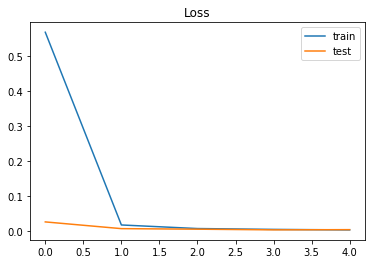

In [0]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

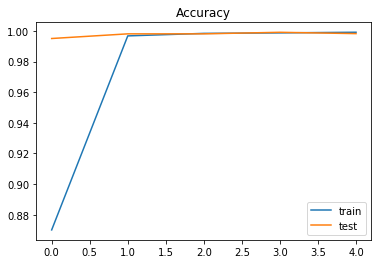

In [0]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [0]:
new_complaint = ['Heartburn, gas, acidity']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Lipitor', 'Pain', 'Myalgia', 'Severe pain', 'Muscle cramp', 'Fatigue', 'Arthralgia', 'Depression', 'Excessive upper gastrointestinal gas', 'Headache', 'Asthenia', 'Backache', 'Pain in lower limb', 'Diarrhoea', 'Muscle weakness', 'Cramp in lower limb', 'Pins and needles', 'Amnesia', 'Insomnia', 'Hip pain', 'Dizziness', 'Walking disability', 'Nausea', 'Knee pain', 'Arthrotec', 'Shoulder pain', 'Stomach ache', 'Foot pain', 'Weakness of limb', 'Arthritis', 'Loss of hair', 'Zocor', 'Myocardial infarction']
print(pred, labels[np.argmax(pred)])

[[6.5255149e-06 1.2367371e-06 6.8735739e-07 1.1103700e-04 2.1820206e-06
  5.1569725e-07 5.6433858e-09 1.5296577e-06 1.4268709e-06 4.2026411e-05
  9.9962533e-01 1.0581390e-06 1.6182249e-06 1.3416008e-09 8.0776664e-07
  6.5582790e-05 1.3703493e-07 3.1569733e-05 1.3636343e-05 1.9895127e-08
  3.9592027e-07 2.0573853e-07 3.4947220e-06 2.0590438e-05 9.8878829e-08
  1.1494516e-06 4.8613526e-08 2.2268096e-05 5.1114949e-07 4.8966922e-06
  6.6794441e-09 3.0835716e-07 1.3134311e-08 3.8946335e-05]] Asthenia


In [0]:
another_complaint = ['Pain in the neck']
seq = tokenizer.texts_to_sequences(another_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Lipitor', 'Pain', 'Myalgia', 'Severe pain', 'Muscle cramp', 'Fatigue', 'Arthralgia', 'Depression', 'Excessive upper gastrointestinal gas', 'Headache', 'Asthenia', 'Backache', 'Pain in lower limb', 'Diarrhoea', 'Muscle weakness', 'Cramp in lower limb', 'Pins and needles', 'Amnesia', 'Insomnia', 'Hip pain', 'Dizziness', 'Walking disability', 'Nausea', 'Knee pain', 'Arthrotec', 'Shoulder pain', 'Stomach ache', 'Foot pain', 'Weakness of limb', 'Arthritis', 'Loss of hair', 'Zocor', 'Myocardial infarction']
print(pred, labels[np.argmax(pred)])

[[4.9162634e-07 1.4958023e-05 9.1673131e-09 8.8487459e-06 5.6023939e-08
  2.8447263e-05 2.4643050e-06 2.3910764e-07 1.3729545e-08 2.5413001e-07
  1.1839016e-06 8.4864200e-07 1.1881411e-03 1.6185430e-06 7.8594872e-05
  1.6700875e-05 1.1577443e-03 1.3739100e-09 5.8848843e-07 3.3959051e-08
  1.7962117e-08 5.0684543e-05 2.6851720e-05 4.4982658e-09 9.9384511e-01
  5.3269789e-05 1.3133249e-03 1.2916973e-05 2.6488685e-04 4.3194747e-04
  1.8639152e-05 1.4283293e-03 8.3485736e-07 5.1904161e-05]] Arthrotec


In [0]:
test0 = pd.read_csv('AskAPatient.fold-0.test.txt', encoding='ISO-8859-1', sep='\t', header = None)
test1 = pd.read_csv('AskAPatient.fold-1.test.txt', encoding='ISO-8859-1', sep='\t', header = None)
test2 = pd.read_csv('AskAPatient.fold-2.test.txt', encoding='ISO-8859-1', sep='\t', header = None)
test3 = pd.read_csv('AskAPatient.fold-3.test.txt', encoding='ISO-8859-1', sep='\t', header = None)
test4 = pd.read_csv('AskAPatient.fold-4.test.txt', encoding='ISO-8859-1', sep='\t', header = None)
test5 = pd.read_csv('AskAPatient.fold-5.test.txt', encoding='ISO-8859-1', sep='\t', header = None)
test6 = pd.read_csv('AskAPatient.fold-6.test.txt', encoding='ISO-8859-1', sep='\t', header = None)
test7 = pd.read_csv('AskAPatient.fold-7.test.txt', encoding='ISO-8859-1', sep='\t', header = None)
test8 = pd.read_csv('AskAPatient.fold-8.test.txt', encoding='ISO-8859-1', sep='\t', header = None)
test9 = pd.read_csv('AskAPatient.fold-9.test.txt', encoding='ISO-8859-1', sep='\t', header = None)

In [0]:
testframes = [test0, test1, test2, test3, test4, test5, test6, test7, test8, test9]

In [0]:
df = pd.concat(testframes)

In [0]:
df.columns = ['CUID', 'Disease', 'Patient Complaint Narrative']

In [104]:
len(df)

8662

Not a lot of data in the test dataset, so we combine them with the validation set.

In [0]:
valid0 = pd.read_csv('AskAPatient.fold-0.validation.txt', encoding='ISO-8859-1', sep='\t', header = None)
valid1 = pd.read_csv('AskAPatient.fold-1.validation.txt', encoding='ISO-8859-1', sep='\t', header = None)
valid2 = pd.read_csv('AskAPatient.fold-2.validation.txt', encoding='ISO-8859-1', sep='\t', header = None)
valid3 = pd.read_csv('AskAPatient.fold-3.validation.txt', encoding='ISO-8859-1', sep='\t', header = None)
valid4 = pd.read_csv('AskAPatient.fold-4.validation.txt', encoding='ISO-8859-1', sep='\t', header = None)
valid5 = pd.read_csv('AskAPatient.fold-5.validation.txt', encoding='ISO-8859-1', sep='\t', header = None)
valid6 = pd.read_csv('AskAPatient.fold-6.validation.txt', encoding='ISO-8859-1', sep='\t', header = None)
valid7 = pd.read_csv('AskAPatient.fold-7.validation.txt', encoding='ISO-8859-1', sep='\t', header = None)
valid8 = pd.read_csv('AskAPatient.fold-8.validation.txt', encoding='ISO-8859-1', sep='\t', header = None)
valid9 = pd.read_csv('AskAPatient.fold-9.validation.txt', encoding='ISO-8859-1', sep='\t', header = None)

In [105]:
validframes = [valid0, valid1, valid2, valid3, valid4, valid5, valid6, valid7, valid8, valid9]
valid= pd.concat(validframes)
#valid.columns = ['CUID', 'Disease', 'Patient Complaint Narrative']
valid.shape

(7926, 3)

In [0]:
test = pd.DataFrame(np.concatenate((df.values,valid.values)),columns=df.columns)

In [18]:
test.shape

(16588, 3)

In [19]:
test.head()

,CUID,Disease,Patient Complaint Narrative
0,108367008,Dislocation of joint,dislocating
1,3384011000036100,Arthrotec,Arthrotec
2,166717003,Serum creatinine raised,elevated creatine
3,3877011000036101,Lipitor,Lipitor
4,402234004,Foot eczema,Eczema on feet


In [17]:
df.CUID.nunique()

1036

In [18]:
df.Disease.nunique()

1040

We already know there are 2 Diseases mapped to more than one CUID from the training dataset.

 Now we need to find out duplicated CUIDs ( 1 CUID mapped to more than 1 Disease)

In [28]:
test.groupby('CUID')['Disease'].apply(lambda x: x.unique().tolist()).to_dict()                           , 

({1402001: ['Fear'],
  1806006: ['Eruption'],
  2733002: ['Heel pain'],
  2764000: ['Joint crepitus'],
  3253007: ['Discolouration of skin'],
  3424008: ['Tachycardia'],
  3545003: ['Diastolic dysfunction'],
  3716002: ['Goitre'],
  3723001: ['Arthritis'],
  4106009: ['Rotator cuff syndrome'],
  4249000: ['Poor peripheral circulation'],
  4308002: ['Repetitive strain injury'],
  4740000: ['Herpes zoster'],
  4969004: ['Sinus pain'],
  5662003: ['Contusion of hand'],
  6020002: ['Tinea pedis'],
  6142004: ['Influenza'],
  6211002: ['Polyarthritis associated with another disorder'],
  6285003: ['Tachycardia'],
  6389006: ['Disturbance in physical behaviour'],
  6471006: ['Suicidal thoughts'],
  7006003: ['Clumsiness'],
  7011001: ['Hallucinations'],
  7393007: ['Disorder of nasal sinus'],
  7501002: ['Increased lactic acid level'],
  7973008: ['Abnormal vision'],
  8009008: ['Nocturnal enuresis'],
  8357008: ['Reduced libido'],
  8392000: ['Non-smoker'],
  8510008: ['Reduced mobility'],


55300003: ['Cramp', 'Muscle Cramp', 'Muscle cramp']
57676002: ['Arthralgia', 'Joint pain'],
95847005: ['Injury of muscle', 'Muscle injury']
129565002: ['Disorder of muscle', 'Myopathy'],
424196004: ['Feeling nervous', 'Nervousness'],

Figure out frequency of duplicated CUIDs across Diseases.

In [29]:
(test['Disease']=='Cramp').sum()

3

In [30]:
(test['Disease']=='Muscle Cramp').sum()

1

In [32]:
(test['Disease']=='Muscle cramp').sum()

262

In [33]:
(test['Disease']=='Feeling nervous').sum()

3

In [34]:
(test['Disease']=='Nervousness').sum()

1

In [35]:
(test['Disease']=='Joint pain').sum()

1

In [36]:
(test['Disease']=='Arthralgia').sum()

256

In [37]:
(test['Disease']=='Injury of muscle').sum()

5

In [38]:
(test['Disease']=='Muscle injury').sum()

1

In [39]:
(test['Disease']=='Disorder of muscle').sum()

4

In [40]:
(test['Disease']=='Myopathy').sum()

59

There is not a lot of information to be gained by keeping the duplicated labels, so we drop the Diseases with lower frequency.

Lablel Consolidation to have one-to-one mapping between CUID & Disease.

In [0]:
test = test[test.Disease != 'Nervousness']
test = test[test.Disease != 'Cramp']
test = test[test.Disease != 'Joint pain']
test = test[test.Disease != 'Muscle Cramp']
test = test[test.Disease != 'Muscle injury']
test = test[test.Disease != 'Disorder of muscle']

In [108]:
test.Disease.nunique()

1034

Now we will remove all rows corresponding to CUIDs that are less than 0.05% of the dataset, same procedure followed for training set.

In [0]:
test = test[test.CUID != 1402001 ]
test = test[test.CUID != 70323002 ]
test = test[test.CUID != 249990003 ]
test = test[test.CUID != 301717006 ]
test = test[test.CUID != 424131007 ]
test = test[test.CUID != 21540011000036109 ]
test = test[test.CUID != 4106009 ]
test = test[test.CUID != 14304000 ]
test = test[test.CUID != 22193007 ]
test = test[test.CUID != 38936003 ]
test = test[test.CUID != 44169009 ]
test = test[test.CUID != 52072009 ]
test = test[test.CUID != 61462000 ]
test = test[test.CUID != 69215007 ]
test = test[test.CUID != 82883008 ]
test = test[test.CUID != 90128006 ]
test = test[test.CUID != 225473001 ]
test = test[test.CUID != 247806005 ]
test = test[test.CUID != 248581005 ]
test = test[test.CUID != 271873000 ]
test = test[test.CUID != 282475008 ]
test = test[test.CUID != 289669005 ]
test = test[test.CUID != 300888008 ]
test = test[test.CUID != 308921004 ]
test = test[test.CUID != 309256001 ]
test = test[test.CUID != 414469009 ]
test = test[test.CUID != 428724006 ]
test = test[test.CUID != 443694000 ]
test = test[test.CUID != 3934011000036103 ]
test = test[test.CUID != 37787011000036104 ]
test = test[test.CUID != 61777011000036104 ]
test = test[test.CUID != 77426011000036108 ]
test = test[test.CUID != 3716002 ]
test = test[test.CUID != 9829001 ]
test = test[test.CUID != 15188001 ]
test = test[test.CUID != 23520002 ]
test = test[test.CUID != 24982008 ]
test = test[test.CUID != 37340000 ]
test = test[test.CUID != 37567005 ]
test = test[test.CUID != 40445007 ]
test = test[test.CUID != 42345000 ]
test = test[test.CUID != 44018007 ]
test = test[test.CUID != 44564008 ]
test = test[test.CUID != 46040000 ]
test = test[test.CUID != 50829006 ]
test = test[test.CUID != 59026006 ]
test = test[test.CUID != 64206003 ]
test = test[test.CUID != 64379006 ]
test = test[test.CUID != 66383009 ]
test = test[test.CUID != 68449006 ]
test = test[test.CUID != 69322001 ]
test = test[test.CUID != 70346000 ]
test = test[test.CUID != 71262003 ]
test = test[test.CUID != 82297005 ]
test = test[test.CUID != 83901003 ]
test = test[test.CUID != 85828009 ]
test = test[test.CUID != 85898001 ]
test = test[test.CUID != 95319004 ]
test = test[test.CUID != 95655001 ]
test = test[test.CUID != 102608004 ]
test = test[test.CUID != 105981003 ]
test = test[test.CUID != 128605003 ]
test = test[test.CUID != 129899009 ]
test = test[test.CUID != 161722004 ]
test = test[test.CUID != 192085004 ]
test = test[test.CUID != 193031009 ]
test = test[test.CUID != 193570009 ]
test = test[test.CUID != 209777000 ]
test = test[test.CUID != 225005002 ]
test = test[test.CUID != 235594008 ]
test = test[test.CUID != 235999009 ]
test = test[test.CUID != 240014001 ]
test = test[test.CUID != 240015000 ]
test = test[test.CUID != 247355005 ]
test = test[test.CUID != 248256006 ]
test = test[test.CUID != 248268002 ]
test = test[test.CUID != 248648003 ]
test = test[test.CUID != 249931001 ]
test = test[test.CUID != 249985001 ]
test = test[test.CUID != 262966007 ]
test = test[test.CUID != 271585001 ]
test = test[test.CUID != 271795006 ]
test = test[test.CUID != 279028009 ]
test = test[test.CUID != 282198006 ]
test = test[test.CUID != 282966001 ]
test = test[test.CUID != 283902008 ]
test = test[test.CUID != 284146005 ]
test = test[test.CUID != 284149003 ]
test = test[test.CUID != 286387000 ]
test = test[test.CUID != 297144002 ]
test = test[test.CUID != 298203008 ]
test = test[test.CUID != 298240000 ]
test = test[test.CUID != 298941006 ]
test = test[test.CUID != 299110002 ]
test = test[test.CUID != 299377003 ]
test = test[test.CUID != 300439004 ]
test = test[test.CUID != 302188001 ]
test = test[test.CUID != 307074005 ]
test = test[test.CUID != 307731004 ]
test = test[test.CUID != 315642008 ]
test = test[test.CUID != 361138002 ]
test = test[test.CUID != 386805003 ]
test = test[test.CUID != 397541004 ]
test = test[test.CUID != 398151007 ]
test = test[test.CUID != 398979000 ]
test = test[test.CUID != 402234004 ]
test = test[test.CUID != 409589004 ]
test = test[test.CUID != 416675009 ]
test = test[test.CUID != 429360005 ]
test = test[test.CUID != 443120002 ]
test = test[test.CUID != 443798008 ]
test = test[test.CUID != 444312002 ]
test = test[test.CUID != 445197008 ]
test = test[test.CUID != 450316000 ]
test = test[test.CUID != 13481000168104 ]
test = test[test.CUID != 250991000119100 ]
test = test[test.CUID != 2922011000036103 ]
test = test[test.CUID != 2940011000036100 ]
test = test[test.CUID != 3066011000036105 ]
test = test[test.CUID != 3527011000036101 ]
test = test[test.CUID != 21589011000036108 ]
test = test[test.CUID != 32972011000036104 ]
test = test[test.CUID != 39592011000036106 ]
test = test[test.CUID != 4308002 ]
test = test[test.CUID != 6020002 ]
test = test[test.CUID != 6389006 ]
test = test[test.CUID != 7501002 ]
test = test[test.CUID != 10085004 ]
test = test[test.CUID != 11381005 ]
test = test[test.CUID != 13644009 ]
test = test[test.CUID != 15203004 ]
test = test[test.CUID != 18156008 ]
test = test[test.CUID != 21499005 ]
test = test[test.CUID != 23388006 ]
test = test[test.CUID != 23919004 ]
test = test[test.CUID != 32402008 ]
test = test[test.CUID != 34789001 ]
test = test[test.CUID != 35064005 ]
test = test[test.CUID != 41931001 ]
test = test[test.CUID != 43364001 ]
test = test[test.CUID != 49563000 ]
test = test[test.CUID != 49601007 ]
test = test[test.CUID != 50415004 ]
test = test[test.CUID != 52754008 ]
test = test[test.CUID != 55222007 ]
test = test[test.CUID != 56018004 ]
test = test[test.CUID != 59976005 ]
test = test[test.CUID != 64531003 ]
test = test[test.CUID != 67015007 ]
test = test[test.CUID != 67362008 ]
test = test[test.CUID != 68172002 ]
test = test[test.CUID != 73442001 ]
test = test[test.CUID != 74732009 ]
test = test[test.CUID != 75183008 ]
test = test[test.CUID != 77981007 ]
test = test[test.CUID != 79015004 ]
test = test[test.CUID != 79395009 ]
test = test[test.CUID != 80515008 ]
test = test[test.CUID != 80585000 ]
test = test[test.CUID != 82470000 ]
test = test[test.CUID != 83156004 ]
test = test[test.CUID != 90834002 ]
test = test[test.CUID != 93478000 ]
test = test[test.CUID != 95677002 ]
test = test[test.CUID != 102911000 ]
test = test[test.CUID != 103281005 ]
test = test[test.CUID != 108367008 ]
test = test[test.CUID != 118930001 ]
test = test[test.CUID != 118940003 ]
test = test[test.CUID != 124042003 ]
test = test[test.CUID != 128609009 ]
test = test[test.CUID != 129859006 ]
test = test[test.CUID != 131053002 ]
test = test[test.CUID != 160591008 ]
test = test[test.CUID != 161156004 ]
test = test[test.CUID != 162315007 ]
test = test[test.CUID != 162351000 ]
test = test[test.CUID != 166702002 ]
test = test[test.CUID != 183202003 ]
test = test[test.CUID != 186748004 ]
test = test[test.CUID != 191736004 ]
test = test[test.CUID != 202609006 ]
test = test[test.CUID != 225460000 ]
test = test[test.CUID != 225482007 ]
test = test[test.CUID != 230490003 ]
test = test[test.CUID != 236071009 ]
test = test[test.CUID != 237602007 ]
test = test[test.CUID != 239725005 ]
test = test[test.CUID != 247412007 ]
test = test[test.CUID != 247761005 ]
test = test[test.CUID != 248493003 ]
test = test[test.CUID != 248657009 ]
test = test[test.CUID != 248966006 ]
test = test[test.CUID != 249544004 ]
test = test[test.CUID != 249903005 ]
test = test[test.CUID != 251377007 ]
test = test[test.CUID != 253522006 ]
test = test[test.CUID != 267076002 ]
test = test[test.CUID != 271771009 ]
test = test[test.CUID != 274135002 ]
test = test[test.CUID != 274141009 ]
test = test[test.CUID != 274646000 ]
test = test[test.CUID != 274665008 ]
test = test[test.CUID != 276294005 ]
test = test[test.CUID != 276444007 ]
test = test[test.CUID != 277890004 ]
test = test[test.CUID != 278286009 ]
test = test[test.CUID != 279043006 ]
test = test[test.CUID != 279063004 ]
test = test[test.CUID != 281794004 ]
test = test[test.CUID != 282926000 ]
test = test[test.CUID != 283121001 ]
test = test[test.CUID != 283416005 ]
test = test[test.CUID != 284136008 ]
test = test[test.CUID != 284252000 ]
test = test[test.CUID != 284977008 ]
test = test[test.CUID != 286651000 ]
test = test[test.CUID != 288225004 ]
test = test[test.CUID != 289001005 ]
test = test[test.CUID != 298170003 ]
test = test[test.CUID != 300650009 ]
test = test[test.CUID != 300895004 ]
test = test[test.CUID != 301657001 ]
test = test[test.CUID != 304297005 ]
test = test[test.CUID != 308909003 ]
test = test[test.CUID != 314642004 ]
test = test[test.CUID != 332982000 ]
test = test[test.CUID != 361122008 ]
test = test[test.CUID != 363406005 ]
test = test[test.CUID != 363499005 ]
test = test[test.CUID != 366979004 ]
test = test[test.CUID != 398114001 ]
test = test[test.CUID != 398152000 ]
test = test[test.CUID != 399044006 ]
test = test[test.CUID != 399068003 ]
test = test[test.CUID != 415692008 ]
test = test[test.CUID != 419511003 ]
test = test[test.CUID != 423849004 ]
test = test[test.CUID != 424372002 ]
test = test[test.CUID != 424582000 ]
test = test[test.CUID != 426120002 ]
test = test[test.CUID != 428281000 ]
test = test[test.CUID != 429661002 ]
test = test[test.CUID != 439953004 ]
test = test[test.CUID != 443892003 ]
test = test[test.CUID != 444003007 ]
test = test[test.CUID != 444702007 ]
test = test[test.CUID != 449618007 ]
test = test[test.CUID != 699302001 ]
test = test[test.CUID != 699376002 ]
test = test[test.CUID != 571000119103 ]
test = test[test.CUID != 14351000168102 ]
test = test[test.CUID != 31911000168108 ]
test = test[test.CUID != 38181000168109 ]
test = test[test.CUID != 45291000168107 ]
test = test[test.CUID != 47401000168109 ]
test = test[test.CUID != 177241000036105 ]
test = test[test.CUID != 3191011000036109 ]
test = test[test.CUID != 3475011000036104 ]
test = test[test.CUID != 3563011000036102 ]
test = test[test.CUID != 3736011000036100 ]
test = test[test.CUID != 6496011000036105 ]
test = test[test.CUID != 21290011000036109 ]
test = test[test.CUID != 21304011000036105 ]
test = test[test.CUID != 21317011000036101 ]
test = test[test.CUID != 21395011000036107 ]
test = test[test.CUID != 21465011000036101 ]
test = test[test.CUID != 21676011000036101 ]
test = test[test.CUID != 21678011000036102 ]
test = test[test.CUID != 21814011000036109 ]
test = test[test.CUID != 37703011000036109 ]
test = test[test.CUID != 39651011000036100 ]
test = test[test.CUID != 39701011000036102 ]
test = test[test.CUID != 69867011000036102 ]
test = test[test.CUID != 83225011000036106 ]
test = test[test.CUID != 1806006 ]
test = test[test.CUID != 4969004 ]
test = test[test.CUID != 5662003 ]
test = test[test.CUID != 6211002 ]
test = test[test.CUID != 7393007 ]
test = test[test.CUID != 7973008 ]
test = test[test.CUID != 8009008 ]
test = test[test.CUID != 10001005 ]
test = test[test.CUID != 12441001 ]
test = test[test.CUID != 13164000 ]
test = test[test.CUID != 13543005 ]
test = test[test.CUID != 14669001 ]
test = test[test.CUID != 15336001 ]
test = test[test.CUID != 16001004 ]
test = test[test.CUID != 18718003 ]
test = test[test.CUID != 19155002 ]
test = test[test.CUID != 25458004 ]
test = test[test.CUID != 26677001 ]
test = test[test.CUID != 35209006 ]
test = test[test.CUID != 36163009 ]
test = test[test.CUID != 38013005 ]
test = test[test.CUID != 39423001 ]
test = test[test.CUID != 40144003 ]
test = test[test.CUID != 40739000 ]
test = test[test.CUID != 41982003 ]
test = test[test.CUID != 45534005 ]
test = test[test.CUID != 46206005 ]
test = test[test.CUID != 48661000 ]
test = test[test.CUID != 51590001 ]
test = test[test.CUID != 52526003 ]
test = test[test.CUID != 54150009 ]
test = test[test.CUID != 55260003 ]
test = test[test.CUID != 55891002 ]
test = test[test.CUID != 56273005 ]
test = test[test.CUID != 56925008 ]
test = test[test.CUID != 58901008 ]
test = test[test.CUID != 63901009 ]
test = test[test.CUID != 64766004 ]
test = test[test.CUID != 64779008 ]
test = test[test.CUID != 75408008 ]
test = test[test.CUID != 76376003 ]
test = test[test.CUID != 79012001 ]
test = test[test.CUID != 80954004 ]
test = test[test.CUID != 80967001 ]
test = test[test.CUID != 81308009 ]
test = test[test.CUID != 82639001 ]
test = test[test.CUID != 84114007 ]
test = test[test.CUID != 84480002 ]
test = test[test.CUID != 86094006 ]
test = test[test.CUID != 89419008 ]
test = test[test.CUID != 95320005 ]
test = test[test.CUID != 95453001 ]
test = test[test.CUID != 95570007 ]
test = test[test.CUID != 95673003 ]
test = test[test.CUID != 102491009 ]
test = test[test.CUID != 102564009 ]
test = test[test.CUID != 102565005 ]
test = test[test.CUID != 102938007 ]
test = test[test.CUID != 103298005 ]
test = test[test.CUID != 110288007 ]
test = test[test.CUID != 111224002 ]
test = test[test.CUID != 119416008 ]
test = test[test.CUID != 125610000 ]
test = test[test.CUID != 127354003 ]
test = test[test.CUID != 128601007 ]
test = test[test.CUID != 131078003 ]
test = test[test.CUID != 160685001 ]
test = test[test.CUID != 161833006 ]
test = test[test.CUID != 161876008 ]
test = test[test.CUID != 161968007 ]
test = test[test.CUID != 162020001 ]
test = test[test.CUID != 162308004 ]
test = test[test.CUID != 166603001 ]
test = test[test.CUID != 193000002 ]
test = test[test.CUID != 194828000 ]
test = test[test.CUID != 202484005 ]
test = test[test.CUID != 202490009 ]
test = test[test.CUID != 202617003 ]
test = test[test.CUID != 225013001 ]
test = test[test.CUID != 225508006 ]
test = test[test.CUID != 230645003 ]
test = test[test.CUID != 230736007 ]
test = test[test.CUID != 236632007 ]
test = test[test.CUID != 238539001 ]
test = test[test.CUID != 239873007 ]
test = test[test.CUID != 246682000 ]
test = test[test.CUID != 246975001 ]
test = test[test.CUID != 247408001 ]
test = test[test.CUID != 247994001 ]
test = test[test.CUID != 248223005 ]
test = test[test.CUID != 248234008 ]
test = test[test.CUID != 248422003 ]
test = test[test.CUID != 248653008 ]
test = test[test.CUID != 249366005 ]
test = test[test.CUID != 249477003 ]
test = test[test.CUID != 249912007 ]
test = test[test.CUID != 249916005 ]
test = test[test.CUID != 254935002 ]
test = test[test.CUID != 267073005 ]
test = test[test.CUID != 267078001 ]
test = test[test.CUID != 267728009 ]
test = test[test.CUID != 271584002 ]
test = test[test.CUID != 271596009 ]
test = test[test.CUID != 271599002 ]
test = test[test.CUID != 271951008 ]
test = test[test.CUID != 272022009 ]
test = test[test.CUID != 278999000 ]
test = test[test.CUID != 279093005 ]
test = test[test.CUID != 282872002 ]
test = test[test.CUID != 282937004 ]
test = test[test.CUID != 283050005 ]
test = test[test.CUID != 285305004 ]
test = test[test.CUID != 285397001 ]
test = test[test.CUID != 287046004 ]
test = test[test.CUID != 289621007 ]
test = test[test.CUID != 298241001 ]
test = test[test.CUID != 298751004 ]
test = test[test.CUID != 298870001 ]
test = test[test.CUID != 299933002 ]
test = test[test.CUID != 300043006 ]
test = test[test.CUID != 300956001 ]
test = test[test.CUID != 301026000 ]
test = test[test.CUID != 301660008 ]
test = test[test.CUID != 307077003 ]
test = test[test.CUID != 307413004 ]
test = test[test.CUID != 309257005 ]
test = test[test.CUID != 309838005 ]
test = test[test.CUID != 314983004 ]
test = test[test.CUID != 363058009 ]
test = test[test.CUID != 372283008 ]
test = test[test.CUID != 387801000 ]
test = test[test.CUID != 401269004 ]
test = test[test.CUID != 420990001 ]
test = test[test.CUID != 423052008 ]
test = test[test.CUID != 425772008 ]
test = test[test.CUID != 440630006 ]
test = test[test.CUID != 473008002 ]
test = test[test.CUID != 609410002 ]
test = test[test.CUID != 699262001 ]
test = test[test.CUID != 699368004 ]
test = test[test.CUID != 3481000168101 ]
test = test[test.CUID != 15611000168108 ]
test = test[test.CUID != 25701000168107 ]
test = test[test.CUID != 59781000168101 ]
test = test[test.CUID != 3003011000036100 ]
test = test[test.CUID != 3589011000036101 ]
test = test[test.CUID != 3659011000036102 ]
test = test[test.CUID != 3702011000036109 ]
test = test[test.CUID != 4156011000036108 ]
test = test[test.CUID != 21605011000036100 ]
test = test[test.CUID != 21624011000036105 ]
test = test[test.CUID != 21747011000036106 ]
test = test[test.CUID != 21809011000036108 ]
test = test[test.CUID != 21839011000036103 ]
test = test[test.CUID != 21911011000036104 ]
test = test[test.CUID != 22095011000036109 ]
test = test[test.CUID != 31645011000036106 ]
test = test[test.CUID != 37714011000036108 ]
test = test[test.CUID != 54020011000036108 ]
test = test[test.CUID != 69821011000036104 ]
test = test[test.CUID != 70270011000036104 ]
test = test[test.CUID != 77442011000036106 ]
test = test[test.CUID != 923927011000036105 ]
test = test[test.CUID != 102598000 ]
test = test[test.CUID != 35918011000036106 ]
test = test[test.CUID != 267038008 ]
test = test[test.CUID != 444899003 ]
test = test[test.CUID != 34839011000036106 ]
test = test[test.CUID != 26413003 ]
test = test[test.CUID != 30811009 ]
test = test[test.CUID != 33308003 ]
test = test[test.CUID != 39621005 ]
test = test[test.CUID != 84946008 ]
test = test[test.CUID != 91019004 ]
test = test[test.CUID != 134407002 ]
test = test[test.CUID != 233604007 ]
test = test[test.CUID != 239965002 ]
test = test[test.CUID != 249898006 ]
test = test[test.CUID != 262558009 ]
test = test[test.CUID != 3545003 ]
test = test[test.CUID != 18165001 ]
test = test[test.CUID != 23502006 ]
test = test[test.CUID != 31681005 ]
test = test[test.CUID != 40806005 ]
test = test[test.CUID != 40930008 ]
test = test[test.CUID != 44548000 ]
test = test[test.CUID != 45979003 ]
test = test[test.CUID != 56317004 ]
test = test[test.CUID != 67233009 ]
test = test[test.CUID != 68235000 ]
test = test[test.CUID != 83421005 ]
test = test[test.CUID != 95359001 ]
test = test[test.CUID != 162221009 ]
test = test[test.CUID != 228148009 ]
test = test[test.CUID != 249940002 ]
test = test[test.CUID != 267045008 ]
test = test[test.CUID != 271737000 ]
test = test[test.CUID != 271787007 ]
test = test[test.CUID != 285849008 ]
test = test[test.CUID != 288332005 ]
test = test[test.CUID != 307496006 ]
test = test[test.CUID != 310495003 ]
test = test[test.CUID != 367466007 ]
test = test[test.CUID != 427475007 ]
test = test[test.CUID != 449614009 ]
test = test[test.CUID != 473011001 ]
test = test[test.CUID != 2531000168109 ]
test = test[test.CUID != 2929011000036108 ]
test = test[test.CUID != 21486011000036105 ]
test = test[test.CUID != 18101008 ]
test = test[test.CUID != 28743005 ]
test = test[test.CUID != 29164008 ]
test = test[test.CUID != 35678005 ]
test = test[test.CUID != 59927004 ]
test = test[test.CUID != 61387006 ]
test = test[test.CUID != 61599003 ]
test = test[test.CUID != 75088002 ]
test = test[test.CUID != 77547008 ]
test = test[test.CUID != 78860006 ]
test = test[test.CUID != 81498004 ]
test = test[test.CUID != 82272006 ]
test = test[test.CUID != 102572006 ]
test = test[test.CUID != 124055002 ]
test = test[test.CUID != 165509000 ]
test = test[test.CUID != 166584001 ]
test = test[test.CUID != 202472008 ]
test = test[test.CUID != 225549006 ]
test = test[test.CUID != 225601007 ]
test = test[test.CUID != 249902000 ]
test = test[test.CUID != 266599000 ]
test = test[test.CUID != 266601003 ]
test = test[test.CUID != 267950000 ]
test = test[test.CUID != 279069000 ]
test = test[test.CUID != 284143002 ]
test = test[test.CUID != 286369003 ]
test = test[test.CUID != 286381004 ]
test = test[test.CUID != 286755001 ]
test = test[test.CUID != 299954009 ]
test = test[test.CUID != 300381009 ]
test = test[test.CUID != 300955002 ]
test = test[test.CUID != 371081002 ]
test = test[test.CUID != 373932008 ]
test = test[test.CUID != 399269003 ]
test = test[test.CUID != 418648005 ]
test = test[test.CUID != 424196004 ]
test = test[test.CUID != 4230011000036107 ]
test = test[test.CUID != 4422011000036109 ]
test = test[test.CUID != 21290011000036100 ]
test = test[test.CUID != 21322011000036108 ]
test = test[test.CUID != 32970011000036103 ]
test = test[test.CUID != 78584011000036106 ]
test = test[test.CUID != 2764000 ]
test = test[test.CUID != 4249000 ]
test = test[test.CUID != 11072008 ]
test = test[test.CUID != 17369002 ]
test = test[test.CUID != 17971005 ]
test = test[test.CUID != 27355003 ]
test = test[test.CUID != 36630001 ]
test = test[test.CUID != 40095003 ]
test = test[test.CUID != 40196000 ]
test = test[test.CUID != 43005009 ]
test = test[test.CUID != 46991000 ]
test = test[test.CUID != 52448006 ]
test = test[test.CUID != 60728008 ]
test = test[test.CUID != 70076002 ]
test = test[test.CUID != 70153002 ]
test = test[test.CUID != 102617004 ]
test = test[test.CUID != 102897001 ]
test = test[test.CUID != 111516008 ]
test = test[test.CUID != 161903000 ]
test = test[test.CUID != 202852009 ]
test = test[test.CUID != 225581002 ]
test = test[test.CUID != 246676003 ]
test = test[test.CUID != 248262001 ]
test = test[test.CUID != 249918006 ]
test = test[test.CUID != 271137009 ]
test = test[test.CUID != 271713000 ]
test = test[test.CUID != 271834000 ]
test = test[test.CUID != 271835004 ]
test = test[test.CUID != 274667000 ]
test = test[test.CUID != 284151004 ]
test = test[test.CUID != 284262007 ]
test = test[test.CUID != 285395009 ]
test = test[test.CUID != 287045000 ]
test = test[test.CUID != 288335007 ]
test = test[test.CUID != 304534000 ]
test = test[test.CUID != 309249007 ]
test = test[test.CUID != 419076005 ]
test = test[test.CUID != 420103007 ]
test = test[test.CUID != 429513001 ]
test = test[test.CUID != 445178008 ]
test = test[test.CUID != 609599003 ]
test = test[test.CUID != 26171000168109 ]
test = test[test.CUID != 2297011000036108 ]
test = test[test.CUID != 21296011000036107 ]
test = test[test.CUID != 21659011000036107 ]
test = test[test.CUID != 76000011000036107 ]
test = test[test.CUID != 77422011000036109 ]
test = test[test.CUID != 21005005 ]
test = test[test.CUID != 31384009 ]
test = test[test.CUID != 41652007 ]
test = test[test.CUID != 44186003 ]
test = test[test.CUID != 105504002 ]
test = test[test.CUID != 122481008 ]
test = test[test.CUID != 128239009 ]
test = test[test.CUID != 249914008 ]
test = test[test.CUID != 249917001 ]
test = test[test.CUID != 266257000 ]
test = test[test.CUID != 267079009 ]
test = test[test.CUID != 370143000 ]
test = test[test.CUID != 371632003 ]
test = test[test.CUID != 397803000 ]
test = test[test.CUID != 415749005 ]
test = test[test.CUID != 421262002 ]
test = test[test.CUID != 426965005 ]
test = test[test.CUID != 429340002 ]
test = test[test.CUID != 21238011000036103 ]
test = test[test.CUID != 68566005 ]
test = test[test.CUID != 224962007 ]
test = test[test.CUID != 16269008 ]
test = test[test.CUID != 249489001 ]
test = test[test.CUID != 3210011000036104 ]
test = test[test.CUID != 21520011000036107 ]
test = test[test.CUID != 3253007 ]
test = test[test.CUID != 22631008 ]
test = test[test.CUID != 46635009 ]
test = test[test.CUID != 53741008 ]
test = test[test.CUID != 80182007 ]
test = test[test.CUID != 445445006 ]
test = test[test.CUID != 21821011000036104 ]
test = test[test.CUID != 7011001 ]
test = test[test.CUID != 8392000 ]
test = test[test.CUID != 13746004 ]
test = test[test.CUID != 34095006 ]
test = test[test.CUID != 36971009 ]
test = test[test.CUID != 43498006 ]
test = test[test.CUID != 67251005 ]
test = test[test.CUID != 130989002 ]
test = test[test.CUID != 165232002 ]
test = test[test.CUID != 202482009 ]
test = test[test.CUID != 225610004 ]
test = test[test.CUID != 299037003 ]
test = test[test.CUID != 3572011000036102 ]
test = test[test.CUID != 6205011000036102 ]
test = test[test.CUID != 21286011000036106 ]
test = test[test.CUID != 10743008 ]
test = test[test.CUID != 21134002 ]
test = test[test.CUID != 30473006 ]
test = test[test.CUID != 44695005 ]
test = test[test.CUID != 52702003 ]
test = test[test.CUID != 95421005 ]
test = test[test.CUID != 95847005 ]
test = test[test.CUID != 161898004 ]
test = test[test.CUID != 167232003 ]
test = test[test.CUID != 236423003 ]
test = test[test.CUID != 237130006 ]
test = test[test.CUID != 238131007 ]
test = test[test.CUID != 239720000 ]
test = test[test.CUID != 249472009 ]
test = test[test.CUID != 271767006 ]
test = test[test.CUID != 271801002 ]
test = test[test.CUID != 274676007 ]
test = test[test.CUID != 280816001 ]
test = test[test.CUID != 299322007 ]
test = test[test.CUID != 315224006 ]
test = test[test.CUID != 361137007 ]
test = test[test.CUID != 371405004 ]
test = test[test.CUID != 397540003 ]
test = test[test.CUID != 698247007 ]
test = test[test.CUID != 69813011000036107 ]
test = test[test.CUID != 4740000 ]
test = test[test.CUID != 7006003 ]
test = test[test.CUID != 14151009 ]
test = test[test.CUID != 18193002 ]
test = test[test.CUID != 26237000 ]
test = test[test.CUID != 42984000 ]
test = test[test.CUID != 48926009 ]
test = test[test.CUID != 55350005 ]
test = test[test.CUID != 61372001 ]
test = test[test.CUID != 102498003 ]
test = test[test.CUID != 102943000 ]
test = test[test.CUID != 118932009 ]
test = test[test.CUID != 247464001 ]
test = test[test.CUID != 247472004 ]
test = test[test.CUID != 275921007 ]
test = test[test.CUID != 277223000 ]
test = test[test.CUID != 308925008 ]
test = test[test.CUID != 309557009 ]
test = test[test.CUID != 448589005 ]
test = test[test.CUID != 6206011000036109 ]
test = test[test.CUID != 32643011000036106 ]
test = test[test.CUID != 12584003 ]
test = test[test.CUID != 22325002 ]
test = test[test.CUID != 64226004 ]
test = test[test.CUID != 82423001 ]
test = test[test.CUID != 95418008 ]
test = test[test.CUID != 103002009 ]
test = test[test.CUID != 129103003 ]
test = test[test.CUID != 166848004 ]
test = test[test.CUID != 202855006 ]
test = test[test.CUID != 279084009 ]
test = test[test.CUID != 282180007 ]
test = test[test.CUID != 417237009 ]
test = test[test.CUID != 424647005 ]
test = test[test.CUID != 429040005 ]
test = test[test.CUID != 609600000 ]
test = test[test.CUID != 101000119102 ]
test = test[test.CUID != 21252011000036100 ]
test = test[test.CUID != 21606011000036107 ]
test = test[test.CUID != 26889001 ]
test = test[test.CUID != 32798002 ]
test = test[test.CUID != 90446007 ]
test = test[test.CUID != 162116003 ]
test = test[test.CUID != 248132003 ]
test = test[test.CUID != 301679006 ]
test = test[test.CUID != 310501001 ]
test = test[test.CUID != 4138011000036106 ]
test = test[test.CUID != 21662011000036107 ]
test = test[test.CUID != 40733004 ]
test = test[test.CUID != 281016006 ]
test = test[test.CUID != 57406009 ]
test = test[test.CUID != 418092006 ]
test = test[test.CUID != 11654001 ]
test = test[test.CUID != 76742009 ]
test = test[test.CUID != 125667009 ]
test = test[test.CUID != 287047008 ]
test = test[test.CUID != 288227007 ]
test = test[test.CUID != 12063002 ]
test = test[test.CUID != 39400004 ]
test = test[test.CUID != 59050008 ]
test = test[test.CUID != 161874006 ]
test = test[test.CUID != 225014007 ]
test = test[test.CUID != 247441003 ]
test = test[test.CUID != 373931001 ]
test = test[test.CUID != 21433011000036107 ]
test = test[test.CUID != 21719011000036107 ]
test = test[test.CUID != 48532005 ]
test = test[test.CUID != 54586004 ]
test = test[test.CUID != 75694006 ]
test = test[test.CUID != 83547004 ]
test = test[test.CUID != 248236005 ]
test = test[test.CUID != 275319005 ]
test = test[test.CUID != 288885009 ]
test = test[test.CUID != 309087008 ]
test = test[test.CUID != 314109004 ]
test = test[test.CUID != 396275006 ]
test = test[test.CUID != 399122003 ]
test = test[test.CUID != 444827008 ]
test = test[test.CUID != 9126005 ]
test = test[test.CUID != 26929004 ]
test = test[test.CUID != 43116000 ]
test = test[test.CUID != 50219008 ]
test = test[test.CUID != 53430007 ]
test = test[test.CUID != 56731001 ]
test = test[test.CUID != 82971005 ]
test = test[test.CUID != 249938007 ]
test = test[test.CUID != 258155009 ]
test = test[test.CUID != 281245003 ]
test = test[test.CUID != 284140004 ]
test = test[test.CUID != 299042006 ]
test = test[test.CUID != 309536001 ]
test = test[test.CUID != 397825006 ]
test = test[test.CUID != 399114005 ]
test = test[test.CUID != 432352001 ]
test = test[test.CUID != 23056005 ]
test = test[test.CUID != 32398004 ]
test = test[test.CUID != 72405004 ]
test = test[test.CUID != 116289008 ]
test = test[test.CUID != 236620008 ]
test = test[test.CUID != 247753000 ]
test = test[test.CUID != 249915009 ]
test = test[test.CUID != 428061005 ]
test = test[test.CUID != 73589001 ]
test = test[test.CUID != 87486003 ]
test = test[test.CUID != 162043005 ]
test = test[test.CUID != 267064002 ]
test = test[test.CUID != 271870002 ]
test = test[test.CUID != 299060006 ]
test = test[test.CUID != 6471006 ]
test = test[test.CUID != 53523011000036100 ]
test = test[test.CUID != 47004009 ]
test = test[test.CUID != 298753001 ]
test = test[test.CUID != 70733008 ]
test = test[test.CUID != 297217002 ]
test = test[test.CUID != 419145002 ]
test = test[test.CUID != 419581008 ]
test = test[test.CUID != 24199005 ]
test = test[test.CUID != 36955009 ]
test = test[test.CUID != 85418005 ]
test = test[test.CUID != 247323005 ]
test = test[test.CUID != 247347003 ]
test = test[test.CUID != 386806002 ]
test = test[test.CUID != 405729008 ]
test = test[test.CUID != 47268002 ]
test = test[test.CUID != 55145008 ]
test = test[test.CUID != 80690008 ]
test = test[test.CUID != 248491001 ]
test = test[test.CUID != 267949000 ]
test = test[test.CUID != 267953003 ]
test = test[test.CUID != 271594007 ]
test = test[test.CUID != 274663001 ]
test = test[test.CUID != 21343011000036103 ]
test = test[test.CUID != 21545007 ]
test = test[test.CUID != 193093009 ]
test = test[test.CUID != 202480001 ]
test = test[test.CUID != 274279008 ]
test = test[test.CUID != 301202006 ]
test = test[test.CUID != 77461011000036109 ]
test = test[test.CUID != 84017003 ]
test = test[test.CUID != 282195009 ]
test = test[test.CUID != 363346000 ]
test = test[test.CUID != 3298011000036103 ]
test = test[test.CUID != 102480002 ]
test = test[test.CUID != 3559011000036109 ]
test = test[test.CUID != 86651002 ]
test = test[test.CUID != 426899007 ]
test = test[test.CUID != 18876004 ]
test = test[test.CUID != 278528006 ]
test = test[test.CUID != 4216011000036104 ]
test = test[test.CUID != 21779011000036103 ]
test = test[test.CUID != 56608008 ]
test = test[test.CUID != 165247006 ]
test = test[test.CUID != 195967001 ]
test = test[test.CUID != 262286000 ]
test = test[test.CUID != 279038004 ]
test = test[test.CUID != 62476001 ]
test = test[test.CUID != 197321007 ]
test = test[test.CUID != 271832001 ]
test = test[test.CUID != 288230000 ]
test = test[test.CUID != 309539008 ]
test = test[test.CUID != 4344011000036106 ]
test = test[test.CUID != 21496011000036106 ]
test = test[test.CUID != 162352007 ]
test = test[test.CUID != 248096004 ]
test = test[test.CUID != 249913002 ]
test = test[test.CUID != 250082003 ]
test = test[test.CUID != 420038007 ]
test = test[test.CUID != 8708008 ]
test = test[test.CUID != 52613005 ]
test = test[test.CUID != 89362005 ]
test = test[test.CUID != 309538000 ]
test = test[test.CUID != 44054006 ]
test = test[test.CUID != 3530011000036104 ]
test = test[test.CUID != 213257006 ]
test = test[test.CUID != 21565011000036108 ]
test = test[test.CUID != 300306001 ]
test = test[test.CUID != 162290004 ]
test = test[test.CUID != 166892002 ]
test = test[test.CUID != 250069006 ]
test = test[test.CUID != 288228002 ]
test = test[test.CUID != 3424008 ]
test = test[test.CUID != 8510008 ]
test = test[test.CUID != 225624000 ]
test = test[test.CUID != 248277009 ]
test = test[test.CUID != 267039000 ]
test = test[test.CUID != 43724002 ]
test = test[test.CUID != 57182000 ]
test = test[test.CUID != 23924001 ]
test = test[test.CUID != 398032003 ]
test = test[test.CUID != 162397003 ]
test = test[test.CUID != 449918009 ]
test = test[test.CUID != 39575007 ]
test = test[test.CUID != 202882003 ]
test = test[test.CUID != 225609009 ]
test = test[test.CUID != 288226003 ]
test = test[test.CUID != 289195008 ]
test = test[test.CUID != 415690000 ]
test = test[test.CUID != 386661006 ]
test = test[test.CUID != 29542008 ]
test = test[test.CUID != 34436003 ]
test = test[test.CUID != 36349006 ]
test = test[test.CUID != 90708001 ]
test = test[test.CUID != 240131006 ]
test = test[test.CUID != 267044007 ]
test = test[test.CUID != 288939007 ]
test = test[test.CUID != 69791001 ]
test = test[test.CUID != 309537005 ]
test = test[test.CUID != 310497006 ]
test = test[test.CUID != 3080011000036109 ]
test = test[test.CUID != 203095000 ]
test = test[test.CUID != 309086004 ]
test = test[test.CUID != 42399005 ]
test = test[test.CUID != 16046003 ]
test = test[test.CUID != 297142003 ]
test = test[test.CUID != 301676004 ]
test = test[test.CUID != 16386004 ]
test = test[test.CUID != 238810007 ]
test = test[test.CUID != 161873000 ]
test = test[test.CUID != 77436011000036106 ]
test = test[test.CUID != 53215011000036102 ]
test = test[test.CUID != 53458011000036102 ]
test = test[test.CUID != 6142004 ]
test = test[test.CUID != 69896004 ]
test = test[test.CUID != 84445001 ]
test = test[test.CUID != 16973004 ]
test = test[test.CUID != 38341003 ]
test = test[test.CUID != 48500005 ]
test = test[test.CUID != 214264003 ]
test = test[test.CUID != 429783005 ]
test = test[test.CUID != 87715008 ]
test = test[test.CUID != 931804011000036107 ]
test = test[test.CUID != 16331000 ]
test = test[test.CUID != 55533009 ]
test = test[test.CUID != 73595000 ]
test = test[test.CUID != 128139000 ]
test = test[test.CUID != 2733002 ]
test = test[test.CUID != 90560007 ]
test = test[test.CUID != 230145002 ]
test = test[test.CUID != 49727002 ]
test = test[test.CUID != 79890006 ]
test = test[test.CUID != 249966004 ]
test = test[test.CUID != 282299006 ]
test = test[test.CUID != 386692008 ]
test = test[test.CUID != 418363000 ]
test = test[test.CUID != 6285003 ]
test = test[test.CUID != 81680008 ]
test = test[test.CUID != 425423002 ]
test = test[test.CUID != 166717003 ]
test = test[test.CUID != 161882006 ]
test = test[test.CUID != 166643006 ]
test = test[test.CUID != 39104002 ]
test = test[test.CUID != 286641001 ]
test = test[test.CUID != 431416001 ]
test = test[test.CUID != 77692006 ]
test = test[test.CUID != 289903006 ]
test = test[test.CUID != 21288011000036105 ]
test = test[test.CUID != 26329005 ]
test = test[test.CUID != 32914008 ]
test = test[test.CUID != 36031001 ]
test = test[test.CUID != 200936003 ]
test = test[test.CUID != 285365001 ]
test = test[test.CUID != 309521004 ]
test = test[test.CUID != 9991008 ]
test = test[test.CUID != 49049000 ]
test = test[test.CUID != 78514002 ]
test = test[test.CUID != 24184005 ]
test = test[test.CUID != 21885011000036105 ]
test = test[test.CUID != 162031009 ]
test = test[test.CUID != 4171011000036100 ]
test = test[test.CUID != 247640008 ]
test = test[test.CUID != 267032009 ]
test = test[test.CUID != 230690007 ]
test = test[test.CUID != 24700007 ]
test = test[test.CUID != 34840004 ]
test = test[test.CUID != 80313002 ]
test = test[test.CUID != 302226006 ]
test = test[test.CUID != 102551008 ]
test = test[test.CUID != 698065002 ]
test = test[test.CUID != 67849003 ]
test = test[test.CUID != 74323005 ]
test = test[test.CUID != 426206001 ]
test = test[test.CUID != 166830008 ]
test = test[test.CUID != 271782001 ]
test = test[test.CUID != 386033004 ]
test = test[test.CUID != 21242011000036102 ]
test = test[test.CUID != 37796009 ]
test = test[test.CUID != 250084002 ]
test = test[test.CUID != 53057004 ]
test = test[test.CUID != 235856003 ]
test = test[test.CUID != 45352006 ]
test = test[test.CUID != 21417011000036105 ]
test = test[test.CUID != 86044005 ]
test = test[test.CUID != 40917007 ]
test = test[test.CUID != 60862001 ]
test = test[test.CUID != 277521002 ]
test = test[test.CUID != 18963009 ]
test = test[test.CUID != 65124004 ]
test = test[test.CUID != 367391008 ]
test = test[test.CUID != 73211009 ]
test = test[test.CUID != 21930011000036101 ]
test = test[test.CUID != 387603000 ]
test = test[test.CUID != 24693007 ]
test = test[test.CUID != 288231001 ]
test = test[test.CUID != 422400008 ]
test = test[test.CUID != 60238002 ]
test = test[test.CUID != 247373008 ]
test = test[test.CUID != 26079004 ]
test = test[test.CUID != 60119000 ]
test = test[test.CUID != 4031011000036106 ]
test = test[test.CUID != 55929007 ]
test = test[test.CUID != 289530006 ]
test = test[test.CUID != 267052005 ]
test = test[test.CUID != 267036007 ]
test = test[test.CUID != 8943002 ]
test = test[test.CUID != 267031002 ]
test = test[test.CUID != 56265001 ]
test = test[test.CUID != 8357008 ]
test = test[test.CUID != 54981004 ]
test = test[test.CUID != 418290006 ]
test = test[test.CUID != 124054003 ]
test = test[test.CUID != 77435011000036104 ]
test = test[test.CUID != 248255005 ]
test = test[test.CUID != 386705008 ]
test = test[test.CUID != 90673000 ]
test = test[test.CUID != 248274002 ]
test = test[test.CUID != 21522001 ]
test = test[test.CUID != 63102001 ]
test = test[test.CUID != 60032008 ]
test = test[test.CUID != 131148009 ]
test = test[test.CUID != 301345002 ]
test = test[test.CUID != 300954003 ]
test = test[test.CUID != 102556003 ]
test = test[test.CUID != 282145008 ]
test = test[test.CUID != 399153001 ]
test = test[test.CUID != 162059005 ]
test = test[test.CUID != 271587009 ]
test = test[test.CUID != 44077006 ]
test = test[test.CUID != 95891005 ]
test = test[test.CUID != 271807003 ]
test = test[test.CUID != 28551000168108 ]
test = test[test.CUID != 80449002 ]
test = test[test.CUID != 51197009 ]
test = test[test.CUID != 29857009 ]
test = test[test.CUID != 3848011000036104 ]
test = test[test.CUID != 247592009 ]
test = test[test.CUID != 248490000 ]
test = test[test.CUID != 129565002 ]
test = test[test.CUID != 14760008 ]
test = test[test.CUID != 48694002 ]
test = test[test.CUID != 279039007 ]
test = test[test.CUID != 246636008 ]
test = test[test.CUID != 386807006 ]
test = test[test.CUID != 82991003 ]
test = test[test.CUID != 88092000 ]
test = test[test.CUID != 224960004 ]
test = test[test.CUID != 419723007 ]
test = test[test.CUID != 77424011000036100 ]

In [110]:
test.shape

(8159, 3)

In [111]:
test.CUID.nunique()

34

In [112]:
test.Disease.nunique()

34

In [47]:
test.Disease.value_counts()

Lipitor                                 2108
Pain                                     713
Myalgia                                  504
Severe pain                              362
Fatigue                                  290
Muscle cramp                             262
Arthralgia                               256
Depression                               234
Excessive upper gastrointestinal gas     229
Headache                                 224
Asthenia                                 203
Pain in lower limb                       157
Backache                                 155
Pins and needles                         145
Insomnia                                 139
Cramp in lower limb                      139
Diarrhoea                                137
Amnesia                                  134
Muscle weakness                          133
Knee pain                                128
Dizziness                                127
Walking disability                       123
Hip pain  

In [0]:
test['Patient Complaint Narrative'] = test['Patient Complaint Narrative'].apply(clean_text)
test['Patient Complaint Narrative'] = test['Patient Complaint Narrative'].str.replace('\d+', '')

BERT

In [50]:
!pip install bert-tensorflow
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import pickle
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
def pretty_print(result):
    df = pd.DataFrame([result]).T
    df.columns = ["values"]
    return df
def create_tokenizer_from_hub_module(bert_model_hub):
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(bert_model_hub)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

def make_features(dataset, label_list, MAX_SEQ_LENGTH, tokenizer, DATA_COLUMN, LABEL_COLUMN):
    input_example = dataset.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)
    features = bert.run_classifier.convert_examples_to_features(input_example, label_list, MAX_SEQ_LENGTH, tokenizer)
    return features

def create_model(bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      bert_model_hub,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(bert_model_hub, num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
#         f1_score = tf.contrib.metrics.f1_score(
#             label_ids,
#             predicted_labels)
#         auc = tf.metrics.auc(
#             label_ids,
#             predicted_labels)
#         recall = tf.metrics.recall(
#             label_ids,
#             predicted_labels)
#         precision = tf.metrics.precision(
#             label_ids,
#             predicted_labels) 
#         true_pos = tf.metrics.true_positives(
#             label_ids,
#             predicted_labels)
#         true_neg = tf.metrics.true_negatives(
#             label_ids,
#             predicted_labels)   
#         false_pos = tf.metrics.false_positives(
#             label_ids,
#             predicted_labels)  
#         false_neg = tf.metrics.false_negatives(
#             label_ids,
#             predicted_labels)
        return {
            "eval_accuracy": accuracy
#             "f1_score": f1_score,
#             "auc": auc,
#             "precision": precision,
#             "recall": recall,
#             "true_positives": true_pos,
#             "true_negatives": true_neg,
#             "false_positives": false_pos,
#             "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

def estimator_builder(bert_model_hub, OUTPUT_DIR, SAVE_SUMMARY_STEPS, SAVE_CHECKPOINTS_STEPS, label_list, LEARNING_RATE, num_train_steps, num_warmup_steps, BATCH_SIZE):

    # Specify outpit directory and number of checkpoint steps to save
    run_config = tf.estimator.RunConfig(
        model_dir=OUTPUT_DIR,
        save_summary_steps=SAVE_SUMMARY_STEPS,
        save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

    model_fn = model_fn_builder(
      bert_model_hub = bert_model_hub,
      num_labels=len(label_list),
      learning_rate=LEARNING_RATE,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps)

    estimator = tf.estimator.Estimator(
      model_fn=model_fn,
      config=run_config,
      params={"batch_size": BATCH_SIZE})
    return estimator, model_fn, run_config

def run_on_dfs(train, test, DATA_COLUMN, LABEL_COLUMN, 
               MAX_SEQ_LENGTH = 128,
              BATCH_SIZE = 32,
              LEARNING_RATE = 2e-5,
              NUM_TRAIN_EPOCHS = 3.0,
              WARMUP_PROPORTION = 0.1,
              SAVE_SUMMARY_STEPS = 100,
               SAVE_CHECKPOINTS_STEPS = 10000,
              bert_model_hub = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"):

    label_list = train[LABEL_COLUMN].unique().tolist()
    
    tokenizer = create_tokenizer_from_hub_module(bert_model_hub)

    train_features = make_features(train, label_list, MAX_SEQ_LENGTH, tokenizer, DATA_COLUMN, LABEL_COLUMN)
    test_features = make_features(test, label_list, MAX_SEQ_LENGTH, tokenizer, DATA_COLUMN, LABEL_COLUMN)

    num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
    num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

    estimator, model_fn, run_config = estimator_builder(
                                  bert_model_hub, 
                                  OUTPUT_DIR, 
                                  SAVE_SUMMARY_STEPS, 
                                  SAVE_CHECKPOINTS_STEPS, 
                                  label_list, 
                                  LEARNING_RATE, 
                                  num_train_steps, 
                                  num_warmup_steps, 
                                  BATCH_SIZE)

    train_input_fn = bert.run_classifier.input_fn_builder(
        features=train_features,
        seq_length=MAX_SEQ_LENGTH,
        is_training=True,
        drop_remainder=False)

    estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)

    test_input_fn = run_classifier.input_fn_builder(
        features=test_features,
        seq_length=MAX_SEQ_LENGTH,
        is_training=False,
        drop_remainder=False)

    result_dict = estimator.evaluate(input_fn=test_input_fn, steps=None)
    return result_dict, estimator
    
import random
random.seed(10)
OUTPUT_DIR = 'output'

    100% |████████████████████████████████| 71kB 27.5MB/s 


W0428 19:57:13.060235 140065210144640 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Shuffle the training and test datasets

In [0]:
train = train.sample(len(train))

In [0]:
test = test.sample(len(test))

In [0]:
myparam = {
    "DATA_COLUMN": "Patient Complaint Narrative",
    "LABEL_COLUMN": "CUID",
    "LEARNING_RATE": 2e-5,
    "NUM_TRAIN_EPOCHS": 2
}

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)

In [72]:
result, estimator = run_on_dfs(train, test, **myparam)

Instructions for updating:
Colocations handled automatically by placer.


W0428 20:05:17.973958 140065210144640 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0428 20:05:19.884446 140065210144640 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Writing example 0 of 76616


I0428 20:05:23.692831 140065210144640 run_classifier.py:774] Writing example 0 of 76616


INFO:tensorflow:*** Example ***


I0428 20:05:23.698815 140065210144640 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0428 20:05:23.701193 140065210144640 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] lip ##itor [SEP]


I0428 20:05:23.704654 140065210144640 run_classifier.py:464] tokens: [CLS] lip ##itor [SEP]


INFO:tensorflow:input_ids: 101 5423 15660 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.708181 140065210144640 run_classifier.py:465] input_ids: 101 5423 15660 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.711582 140065210144640 run_classifier.py:466] input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.714922 140065210144640 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3877011000036101 (id = 0)


I0428 20:05:23.718126 140065210144640 run_classifier.py:468] label: 3877011000036101 (id = 0)


INFO:tensorflow:*** Example ***


I0428 20:05:23.721572 140065210144640 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0428 20:05:23.724570 140065210144640 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] severe lower back pain [SEP]


I0428 20:05:23.727777 140065210144640 run_classifier.py:464] tokens: [CLS] severe lower back pain [SEP]


INFO:tensorflow:input_ids: 101 5729 2896 2067 3255 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.730994 140065210144640 run_classifier.py:465] input_ids: 101 5729 2896 2067 3255 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.733461 140065210144640 run_classifier.py:466] input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.735379 140065210144640 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 76948002 (id = 1)


I0428 20:05:23.737402 140065210144640 run_classifier.py:468] label: 76948002 (id = 1)


INFO:tensorflow:*** Example ***


I0428 20:05:23.739365 140065210144640 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0428 20:05:23.741125 140065210144640 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] back ##ache [SEP]


I0428 20:05:23.743172 140065210144640 run_classifier.py:464] tokens: [CLS] back ##ache [SEP]


INFO:tensorflow:input_ids: 101 2067 15395 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.744992 140065210144640 run_classifier.py:465] input_ids: 101 2067 15395 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.746842 140065210144640 run_classifier.py:466] input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.748634 140065210144640 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 161891005 (id = 2)


I0428 20:05:23.750646 140065210144640 run_classifier.py:468] label: 161891005 (id = 2)


INFO:tensorflow:*** Example ***


I0428 20:05:23.752572 140065210144640 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0428 20:05:23.754436 140065210144640 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] lip ##itor [SEP]


I0428 20:05:23.756488 140065210144640 run_classifier.py:464] tokens: [CLS] lip ##itor [SEP]


INFO:tensorflow:input_ids: 101 5423 15660 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.758412 140065210144640 run_classifier.py:465] input_ids: 101 5423 15660 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.760599 140065210144640 run_classifier.py:466] input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.762614 140065210144640 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3877011000036101 (id = 0)


I0428 20:05:23.764592 140065210144640 run_classifier.py:468] label: 3877011000036101 (id = 0)


INFO:tensorflow:*** Example ***


I0428 20:05:23.766956 140065210144640 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0428 20:05:23.768877 140065210144640 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] depression [SEP]


I0428 20:05:23.770771 140065210144640 run_classifier.py:464] tokens: [CLS] depression [SEP]


INFO:tensorflow:input_ids: 101 6245 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.772709 140065210144640 run_classifier.py:465] input_ids: 101 6245 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.775038 140065210144640 run_classifier.py:466] input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:23.776840 140065210144640 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 35489007 (id = 3)


I0428 20:05:23.778972 140065210144640 run_classifier.py:468] label: 35489007 (id = 3)


INFO:tensorflow:Writing example 10000 of 76616


I0428 20:05:24.896277 140065210144640 run_classifier.py:774] Writing example 10000 of 76616


INFO:tensorflow:Writing example 20000 of 76616


I0428 20:05:25.859078 140065210144640 run_classifier.py:774] Writing example 20000 of 76616


INFO:tensorflow:Writing example 30000 of 76616


I0428 20:05:27.005501 140065210144640 run_classifier.py:774] Writing example 30000 of 76616


INFO:tensorflow:Writing example 40000 of 76616


I0428 20:05:27.983731 140065210144640 run_classifier.py:774] Writing example 40000 of 76616


INFO:tensorflow:Writing example 50000 of 76616


I0428 20:05:29.193648 140065210144640 run_classifier.py:774] Writing example 50000 of 76616


INFO:tensorflow:Writing example 60000 of 76616


I0428 20:05:30.151731 140065210144640 run_classifier.py:774] Writing example 60000 of 76616


INFO:tensorflow:Writing example 70000 of 76616


I0428 20:05:31.108490 140065210144640 run_classifier.py:774] Writing example 70000 of 76616


INFO:tensorflow:Writing example 0 of 8159


I0428 20:05:31.923051 140065210144640 run_classifier.py:774] Writing example 0 of 8159


INFO:tensorflow:*** Example ***


I0428 20:05:31.924980 140065210144640 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0428 20:05:31.926449 140065210144640 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] lip ##itor [SEP]


I0428 20:05:31.927977 140065210144640 run_classifier.py:464] tokens: [CLS] lip ##itor [SEP]


INFO:tensorflow:input_ids: 101 5423 15660 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:31.929735 140065210144640 run_classifier.py:465] input_ids: 101 5423 15660 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:31.933910 140065210144640 run_classifier.py:466] input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:31.936716 140065210144640 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3877011000036101 (id = 0)


I0428 20:05:31.939437 140065210144640 run_classifier.py:468] label: 3877011000036101 (id = 0)


INFO:tensorflow:*** Example ***


I0428 20:05:31.942728 140065210144640 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0428 20:05:31.950407 140065210144640 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] pain [SEP]


I0428 20:05:31.953927 140065210144640 run_classifier.py:464] tokens: [CLS] pain [SEP]


INFO:tensorflow:input_ids: 101 3255 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:31.955490 140065210144640 run_classifier.py:465] input_ids: 101 3255 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:31.957832 140065210144640 run_classifier.py:466] input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:31.960772 140065210144640 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 22253000 (id = 4)


I0428 20:05:31.963914 140065210144640 run_classifier.py:468] label: 22253000 (id = 4)


INFO:tensorflow:*** Example ***


I0428 20:05:31.966857 140065210144640 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0428 20:05:31.969743 140065210144640 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] cr ##amp ##ing [SEP]


I0428 20:05:31.972484 140065210144640 run_classifier.py:464] tokens: [CLS] cr ##amp ##ing [SEP]


INFO:tensorflow:input_ids: 101 13675 16613 2075 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:31.975304 140065210144640 run_classifier.py:465] input_ids: 101 13675 16613 2075 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:31.979086 140065210144640 run_classifier.py:466] input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:31.981777 140065210144640 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 55300003 (id = 10)


I0428 20:05:31.983818 140065210144640 run_classifier.py:468] label: 55300003 (id = 10)


INFO:tensorflow:*** Example ***


I0428 20:05:31.986309 140065210144640 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0428 20:05:31.988615 140065210144640 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] lip ##itor [SEP]


I0428 20:05:31.990939 140065210144640 run_classifier.py:464] tokens: [CLS] lip ##itor [SEP]


INFO:tensorflow:input_ids: 101 5423 15660 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:31.993069 140065210144640 run_classifier.py:465] input_ids: 101 5423 15660 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:31.995375 140065210144640 run_classifier.py:466] input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:31.997725 140065210144640 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3877011000036101 (id = 0)


I0428 20:05:31.999594 140065210144640 run_classifier.py:468] label: 3877011000036101 (id = 0)


INFO:tensorflow:*** Example ***


I0428 20:05:32.002083 140065210144640 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0428 20:05:32.004426 140065210144640 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] lass ##itude [SEP]


I0428 20:05:32.006765 140065210144640 run_classifier.py:464] tokens: [CLS] lass ##itude [SEP]


INFO:tensorflow:input_ids: 101 27333 18679 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:32.008765 140065210144640 run_classifier.py:465] input_ids: 101 27333 18679 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:32.011176 140065210144640 run_classifier.py:466] input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0428 20:05:32.013238 140065210144640 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 13791008 (id = 29)


I0428 20:05:32.015487 140065210144640 run_classifier.py:468] label: 13791008 (id = 29)


INFO:tensorflow:Using config: {'_model_dir': 'output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6304fd7470>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0428 20:05:33.198300 140065210144640 estimator.py:201] Using config: {'_model_dir': 'output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6304fd7470>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0428 20:06:12.190469 140065210144640 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0428 20:06:15.618184 140065210144640 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0428 20:06:15.754382 140065210144640 deprecation.py:506] From <ipython-input-50-68baafc3d0f7>:67: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0428 20:06:15.805460 140065210144640 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/learning_rate_decay_v2.py:321: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Use tf.cast instead.


W0428 20:06:15.894107 140065210144640 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Instructions for updating:
Use tf.cast instead.


W0428 20:06:24.924339 140065210144640 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/metrics_impl.py:455: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Done calling model_fn.


I0428 20:06:24.945197 140065210144640 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0428 20:06:24.948764 140065210144640 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0428 20:06:29.820400 140065210144640 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0428 20:06:34.224690 140065210144640 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0428 20:06:34.410010 140065210144640 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into output/model.ckpt.


I0428 20:07:08.602130 140065210144640 basic_session_run_hooks.py:594] Saving checkpoints for 0 into output/model.ckpt.


INFO:tensorflow:loss = 3.689167, step = 0


I0428 20:07:26.117032 140065210144640 basic_session_run_hooks.py:249] loss = 3.689167, step = 0


INFO:tensorflow:global_step/sec: 1.0843


I0428 20:08:58.342025 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.0843


INFO:tensorflow:loss = 2.1454618, step = 100 (92.232 sec)


I0428 20:08:58.349461 140065210144640 basic_session_run_hooks.py:247] loss = 2.1454618, step = 100 (92.232 sec)


INFO:tensorflow:global_step/sec: 1.21482


I0428 20:10:20.658796 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21482


INFO:tensorflow:loss = 0.8054373, step = 200 (82.316 sec)


I0428 20:10:20.665618 140065210144640 basic_session_run_hooks.py:247] loss = 0.8054373, step = 200 (82.316 sec)


INFO:tensorflow:global_step/sec: 1.21325


I0428 20:11:43.082163 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21325


INFO:tensorflow:loss = 0.33940518, step = 300 (82.419 sec)


I0428 20:11:43.084766 140065210144640 basic_session_run_hooks.py:247] loss = 0.33940518, step = 300 (82.419 sec)


INFO:tensorflow:global_step/sec: 1.21436


I0428 20:13:05.430342 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21436


INFO:tensorflow:loss = 0.16827881, step = 400 (82.351 sec)


I0428 20:13:05.435337 140065210144640 basic_session_run_hooks.py:247] loss = 0.16827881, step = 400 (82.351 sec)


INFO:tensorflow:global_step/sec: 1.21454


I0428 20:14:27.766331 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21454


INFO:tensorflow:loss = 0.039399102, step = 500 (82.334 sec)


I0428 20:14:27.769626 140065210144640 basic_session_run_hooks.py:247] loss = 0.039399102, step = 500 (82.334 sec)


INFO:tensorflow:global_step/sec: 1.214


I0428 20:15:50.138803 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.214


INFO:tensorflow:loss = 0.025514461, step = 600 (82.376 sec)


I0428 20:15:50.145228 140065210144640 basic_session_run_hooks.py:247] loss = 0.025514461, step = 600 (82.376 sec)


INFO:tensorflow:global_step/sec: 1.21392


I0428 20:17:12.516631 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21392


INFO:tensorflow:loss = 0.042575706, step = 700 (82.374 sec)


I0428 20:17:12.519232 140065210144640 basic_session_run_hooks.py:247] loss = 0.042575706, step = 700 (82.374 sec)


INFO:tensorflow:global_step/sec: 1.21529


I0428 20:18:34.801327 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21529


INFO:tensorflow:loss = 0.016486987, step = 800 (82.285 sec)


I0428 20:18:34.803984 140065210144640 basic_session_run_hooks.py:247] loss = 0.016486987, step = 800 (82.285 sec)


INFO:tensorflow:global_step/sec: 1.21529


I0428 20:19:57.085937 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21529


INFO:tensorflow:loss = 0.015944201, step = 900 (82.287 sec)


I0428 20:19:57.090497 140065210144640 basic_session_run_hooks.py:247] loss = 0.015944201, step = 900 (82.287 sec)


INFO:tensorflow:global_step/sec: 1.21558


I0428 20:21:19.351007 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21558


INFO:tensorflow:loss = 0.017382205, step = 1000 (82.265 sec)


I0428 20:21:19.355200 140065210144640 basic_session_run_hooks.py:247] loss = 0.017382205, step = 1000 (82.265 sec)


INFO:tensorflow:global_step/sec: 1.21628


I0428 20:22:41.568627 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21628


INFO:tensorflow:loss = 0.010494926, step = 1100 (82.220 sec)


I0428 20:22:41.574920 140065210144640 basic_session_run_hooks.py:247] loss = 0.010494926, step = 1100 (82.220 sec)


INFO:tensorflow:global_step/sec: 1.21644


I0428 20:24:03.775862 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21644


INFO:tensorflow:loss = 0.008499403, step = 1200 (82.205 sec)


I0428 20:24:03.780320 140065210144640 basic_session_run_hooks.py:247] loss = 0.008499403, step = 1200 (82.205 sec)


INFO:tensorflow:global_step/sec: 1.21453


I0428 20:25:26.112324 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21453


INFO:tensorflow:loss = 0.005955285, step = 1300 (82.336 sec)


I0428 20:25:26.117415 140065210144640 basic_session_run_hooks.py:247] loss = 0.005955285, step = 1300 (82.336 sec)


INFO:tensorflow:global_step/sec: 1.21536


I0428 20:26:48.392227 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21536


INFO:tensorflow:loss = 0.00556003, step = 1400 (82.278 sec)


I0428 20:26:48.394394 140065210144640 basic_session_run_hooks.py:247] loss = 0.00556003, step = 1400 (82.278 sec)


INFO:tensorflow:global_step/sec: 1.21565


I0428 20:28:10.652733 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21565


INFO:tensorflow:loss = 0.0051469915, step = 1500 (82.263 sec)


I0428 20:28:10.657716 140065210144640 basic_session_run_hooks.py:247] loss = 0.0051469915, step = 1500 (82.263 sec)


INFO:tensorflow:global_step/sec: 1.21642


I0428 20:29:32.860817 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21642


INFO:tensorflow:loss = 0.0059061814, step = 1600 (82.209 sec)


I0428 20:29:32.867727 140065210144640 basic_session_run_hooks.py:247] loss = 0.0059061814, step = 1600 (82.209 sec)


INFO:tensorflow:global_step/sec: 1.21658


I0428 20:30:55.058643 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21658


INFO:tensorflow:loss = 0.0033819028, step = 1700 (82.195 sec)


I0428 20:30:55.061980 140065210144640 basic_session_run_hooks.py:247] loss = 0.0033819028, step = 1700 (82.195 sec)


INFO:tensorflow:global_step/sec: 1.21597


I0428 20:32:17.297811 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21597


INFO:tensorflow:loss = 0.11510964, step = 1800 (82.238 sec)


I0428 20:32:17.300017 140065210144640 basic_session_run_hooks.py:247] loss = 0.11510964, step = 1800 (82.238 sec)


INFO:tensorflow:global_step/sec: 1.21557


I0428 20:33:39.563991 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21557


INFO:tensorflow:loss = 0.003365789, step = 1900 (82.266 sec)


I0428 20:33:39.566138 140065210144640 basic_session_run_hooks.py:247] loss = 0.003365789, step = 1900 (82.266 sec)


INFO:tensorflow:global_step/sec: 1.21605


I0428 20:35:01.797558 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21605


INFO:tensorflow:loss = 0.0034095156, step = 2000 (82.233 sec)


I0428 20:35:01.799636 140065210144640 basic_session_run_hooks.py:247] loss = 0.0034095156, step = 2000 (82.233 sec)


INFO:tensorflow:global_step/sec: 1.21606


I0428 20:36:24.030334 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21606


INFO:tensorflow:loss = 0.003397765, step = 2100 (82.233 sec)


I0428 20:36:24.032980 140065210144640 basic_session_run_hooks.py:247] loss = 0.003397765, step = 2100 (82.233 sec)


INFO:tensorflow:global_step/sec: 1.21546


I0428 20:37:46.303877 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21546


INFO:tensorflow:loss = 0.0027317917, step = 2200 (82.273 sec)


I0428 20:37:46.305986 140065210144640 basic_session_run_hooks.py:247] loss = 0.0027317917, step = 2200 (82.273 sec)


INFO:tensorflow:global_step/sec: 1.21623


I0428 20:39:08.525151 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21623


INFO:tensorflow:loss = 0.0027981321, step = 2300 (82.221 sec)


I0428 20:39:08.527250 140065210144640 basic_session_run_hooks.py:247] loss = 0.0027981321, step = 2300 (82.221 sec)


INFO:tensorflow:global_step/sec: 1.21587


I0428 20:40:30.771041 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21587


INFO:tensorflow:loss = 0.0021761272, step = 2400 (82.246 sec)


I0428 20:40:30.773493 140065210144640 basic_session_run_hooks.py:247] loss = 0.0021761272, step = 2400 (82.246 sec)


INFO:tensorflow:global_step/sec: 1.21627


I0428 20:41:52.989768 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21627


INFO:tensorflow:loss = 0.0024057939, step = 2500 (82.218 sec)


I0428 20:41:52.991779 140065210144640 basic_session_run_hooks.py:247] loss = 0.0024057939, step = 2500 (82.218 sec)


INFO:tensorflow:global_step/sec: 1.21477


I0428 20:43:15.309838 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21477


INFO:tensorflow:loss = 0.0023626476, step = 2600 (82.323 sec)


I0428 20:43:15.314939 140065210144640 basic_session_run_hooks.py:247] loss = 0.0023626476, step = 2600 (82.323 sec)


INFO:tensorflow:global_step/sec: 1.21412


I0428 20:44:37.674220 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21412


INFO:tensorflow:loss = 0.0019692876, step = 2700 (82.362 sec)


I0428 20:44:37.676904 140065210144640 basic_session_run_hooks.py:247] loss = 0.0019692876, step = 2700 (82.362 sec)


INFO:tensorflow:global_step/sec: 1.21438


I0428 20:46:00.020499 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21438


INFO:tensorflow:loss = 0.0026076057, step = 2800 (82.348 sec)


I0428 20:46:00.024414 140065210144640 basic_session_run_hooks.py:247] loss = 0.0026076057, step = 2800 (82.348 sec)


INFO:tensorflow:global_step/sec: 1.21391


I0428 20:47:22.398918 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21391


INFO:tensorflow:loss = 0.0022026098, step = 2900 (82.380 sec)


I0428 20:47:22.404387 140065210144640 basic_session_run_hooks.py:247] loss = 0.0022026098, step = 2900 (82.380 sec)


INFO:tensorflow:global_step/sec: 1.21322


I0428 20:48:44.824097 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21322


INFO:tensorflow:loss = 0.0034671943, step = 3000 (82.424 sec)


I0428 20:48:44.828829 140065210144640 basic_session_run_hooks.py:247] loss = 0.0034671943, step = 3000 (82.424 sec)


INFO:tensorflow:global_step/sec: 1.21461


I0428 20:50:07.155068 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21461


INFO:tensorflow:loss = 0.0015899389, step = 3100 (82.329 sec)


I0428 20:50:07.157294 140065210144640 basic_session_run_hooks.py:247] loss = 0.0015899389, step = 3100 (82.329 sec)


INFO:tensorflow:global_step/sec: 1.21446


I0428 20:51:29.496000 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21446


INFO:tensorflow:loss = 0.0018258407, step = 3200 (82.341 sec)


I0428 20:51:29.498104 140065210144640 basic_session_run_hooks.py:247] loss = 0.0018258407, step = 3200 (82.341 sec)


INFO:tensorflow:global_step/sec: 1.21572


I0428 20:52:51.751548 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21572


INFO:tensorflow:loss = 0.0014625553, step = 3300 (82.260 sec)


I0428 20:52:51.758006 140065210144640 basic_session_run_hooks.py:247] loss = 0.0014625553, step = 3300 (82.260 sec)


INFO:tensorflow:global_step/sec: 1.21622


I0428 20:54:13.973249 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21622


INFO:tensorflow:loss = 0.0017732114, step = 3400 (82.218 sec)


I0428 20:54:13.975681 140065210144640 basic_session_run_hooks.py:247] loss = 0.0017732114, step = 3400 (82.218 sec)


INFO:tensorflow:global_step/sec: 1.21675


I0428 20:55:36.159314 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21675


INFO:tensorflow:loss = 0.12896118, step = 3500 (82.191 sec)


I0428 20:55:36.166481 140065210144640 basic_session_run_hooks.py:247] loss = 0.12896118, step = 3500 (82.191 sec)


INFO:tensorflow:global_step/sec: 1.21634


I0428 20:56:58.373119 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21634


INFO:tensorflow:loss = 0.001431486, step = 3600 (82.209 sec)


I0428 20:56:58.375534 140065210144640 basic_session_run_hooks.py:247] loss = 0.001431486, step = 3600 (82.209 sec)


INFO:tensorflow:global_step/sec: 1.2155


I0428 20:58:20.643614 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.2155


INFO:tensorflow:loss = 0.0015695256, step = 3700 (82.273 sec)


I0428 20:58:20.648282 140065210144640 basic_session_run_hooks.py:247] loss = 0.0015695256, step = 3700 (82.273 sec)


INFO:tensorflow:global_step/sec: 1.21666


I0428 20:59:42.835823 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21666


INFO:tensorflow:loss = 0.00162163, step = 3800 (82.192 sec)


I0428 20:59:42.840205 140065210144640 basic_session_run_hooks.py:247] loss = 0.00162163, step = 3800 (82.192 sec)


INFO:tensorflow:global_step/sec: 1.21677


I0428 21:01:05.020832 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21677


INFO:tensorflow:loss = 0.0013536083, step = 3900 (82.188 sec)


I0428 21:01:05.027907 140065210144640 basic_session_run_hooks.py:247] loss = 0.0013536083, step = 3900 (82.188 sec)


INFO:tensorflow:global_step/sec: 1.21703


I0428 21:02:27.188207 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21703


INFO:tensorflow:loss = 0.0013155465, step = 4000 (82.163 sec)


I0428 21:02:27.191010 140065210144640 basic_session_run_hooks.py:247] loss = 0.0013155465, step = 4000 (82.163 sec)


INFO:tensorflow:global_step/sec: 1.21556


I0428 21:03:49.454563 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21556


INFO:tensorflow:loss = 0.0013726784, step = 4100 (82.266 sec)


I0428 21:03:49.456657 140065210144640 basic_session_run_hooks.py:247] loss = 0.0013726784, step = 4100 (82.266 sec)


INFO:tensorflow:global_step/sec: 1.21508


I0428 21:05:11.753431 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21508


INFO:tensorflow:loss = 0.0012592764, step = 4200 (82.299 sec)


I0428 21:05:11.755739 140065210144640 basic_session_run_hooks.py:247] loss = 0.0012592764, step = 4200 (82.299 sec)


INFO:tensorflow:global_step/sec: 1.21585


I0428 21:06:34.000554 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21585


INFO:tensorflow:loss = 0.0018862518, step = 4300 (82.248 sec)


I0428 21:06:34.003913 140065210144640 basic_session_run_hooks.py:247] loss = 0.0018862518, step = 4300 (82.248 sec)


INFO:tensorflow:global_step/sec: 1.21664


I0428 21:07:56.194179 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21664


INFO:tensorflow:loss = 0.001183694, step = 4400 (82.197 sec)


I0428 21:07:56.201159 140065210144640 basic_session_run_hooks.py:247] loss = 0.001183694, step = 4400 (82.197 sec)


INFO:tensorflow:global_step/sec: 1.21597


I0428 21:09:18.432900 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21597


INFO:tensorflow:loss = 0.0012403375, step = 4500 (82.236 sec)


I0428 21:09:18.437471 140065210144640 basic_session_run_hooks.py:247] loss = 0.0012403375, step = 4500 (82.236 sec)


INFO:tensorflow:global_step/sec: 1.21417


I0428 21:10:40.793591 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21417


INFO:tensorflow:loss = 0.0025794506, step = 4600 (82.360 sec)


I0428 21:10:40.797770 140065210144640 basic_session_run_hooks.py:247] loss = 0.0025794506, step = 4600 (82.360 sec)


INFO:tensorflow:global_step/sec: 1.21567


I0428 21:12:03.052891 140065210144640 basic_session_run_hooks.py:680] global_step/sec: 1.21567


INFO:tensorflow:loss = 0.0016832815, step = 4700 (82.259 sec)


I0428 21:12:03.057004 140065210144640 basic_session_run_hooks.py:247] loss = 0.0016832815, step = 4700 (82.259 sec)


INFO:tensorflow:Saving checkpoints for 4788 into output/model.ckpt.


I0428 21:13:14.669210 140065210144640 basic_session_run_hooks.py:594] Saving checkpoints for 4788 into output/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0011584957.


I0428 21:13:25.152693 140065210144640 estimator.py:359] Loss for final step: 0.0011584957.


INFO:tensorflow:Calling model_fn.


I0428 21:13:29.408139 140065210144640 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0428 21:13:32.597729 140065210144640 saver.py:1483] Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



INFO:tensorflow:Done calling model_fn.


I0428 21:13:41.056391 140065210144640 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-04-28T21:13:41Z


I0428 21:13:41.080495 140065210144640 evaluation.py:257] Starting evaluation at 2019-04-28T21:13:41Z


INFO:tensorflow:Graph was finalized.


I0428 21:13:42.443125 140065210144640 monitored_session.py:222] Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0428 21:13:42.452121 140065210144640 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from output/model.ckpt-4788


I0428 21:13:42.458449 140065210144640 saver.py:1270] Restoring parameters from output/model.ckpt-4788


INFO:tensorflow:Running local_init_op.


I0428 21:13:44.600705 140065210144640 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0428 21:13:44.823041 140065210144640 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-04-28-21:14:57


I0428 21:14:57.425334 140065210144640 evaluation.py:277] Finished evaluation at 2019-04-28-21:14:57


INFO:tensorflow:Saving dict for global step 4788: eval_accuracy = 0.9982841, global_step = 4788, loss = 0.0068991603


I0428 21:14:57.429787 140065210144640 estimator.py:1979] Saving dict for global step 4788: eval_accuracy = 0.9982841, global_step = 4788, loss = 0.0068991603


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4788: output/model.ckpt-4788


I0428 21:14:59.570740 140065210144640 estimator.py:2039] Saving 'checkpoint_path' summary for global step 4788: output/model.ckpt-4788


In [86]:
result

{'eval_accuracy': 0.9982841, 'global_step': 4788, 'loss': 0.0068991603}

Fast ai

In [0]:
import fastai 
from fastai import * 
from fastai.text import * 

In [0]:
train.columns = ['label', 'Disease', 'text']

In [0]:
train = train.drop(['Disease'], axis = 1)

In [0]:
test.columns = ['label', 'Disease', 'text']

In [0]:
test = test.drop(['Disease'], axis = 1)

In [0]:
# Language model data 
data_lm = TextLMDataBunch.from_df(train_df = train, valid_df = test, path = './') 

In [0]:
data_lm.save()

In [67]:
print(data_lm.train_ds.vocab.itos)

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', 'lipitor', 'pain', 'muscle', 'severe', 'myalgia', 'fatigue', 'weakness', 'cramp', 'limb', 'depression', 'gas', 'lower', 'headache', 'loss', 'arthralgia', 'upper', 'excessive', 'gastrointestinal', 'hip', 'insomnia', 'arthrotec', 'stomach', 'asthenia', 'nausea', 'knee', 'shoulder', 'joint', 'dizziness', 'cramps', 'leg', 'neck', 'back', 'pains', 'arthritis', 'backache', 'hair', 'zocor', 'foot', 'ache', 'pins', 'needles', 'diarrhoea', 'walking', 'amnesia', 'legs', 'extreme', 'disability', 'aches', 'memory', 'headaches', 'tingling', 'infarction', 'muscles', 'myocardial', 'cramping', 'walk', 'diarrhea', 'feet', 'sore', 'weak', 'heart', 'joints', 'attack', 'hurt', 'knees', 'shoulders', 'hips', 'could', 'painful', 'left', 'spasms', 'soreness', 'strength', 'depressed', 'general', 'arms', 'bad', 'intense', 'aching', 'liptor', 'fatigued', 'feeling', 'arm', 'discomfort', 'nt', 'dizzy', 'hardly', 'right', 'tiredness',

In [68]:
data_lm.show_batch()

idx,text
0,lipitor xxbos amnesia xxbos myalgia xxbos lipitor xxbos arthralgia xxbos lipitor xxbos pain xxbos excessive upper gastrointestinal gas xxbos lipitor xxbos fatigue xxbos fatigue xxbos myalgia xxbos lipitor xxbos stomach ache xxbos lipitor xxbos lipitor xxbos knee pain xxbos neck pain xxbos pain xxbos hip pain xxbos hip pain xxbos muscle weakness xxbos pain lower limb xxbos excessive upper gastrointestinal gas xxbos diarrhoea xxbos lipitor xxbos dizziness xxbos severe pain
1,lipitor xxbos pain xxbos pain xxbos muscle pain xxbos myalgia xxbos fatigue xxbos fatigue xxbos leg cramps xxbos cramp lower limb xxbos lipitor xxbos lipitor xxbos shoulders ache xxbos shoulder pain xxbos lipitor xxbos lipitor xxbos muscle weakness xxbos muscle weakness xxbos depression xxbos depression xxbos severe pain xxbos headache xxbos lipitor xxbos lipitor xxbos pain knees xxbos knee pain xxbos lipitor xxbos lipitor xxbos gas xxbos excessive upper gastrointestinal
2,xxbos pain xxbos shoulder pain xxbos shoulder pain xxbos lipitor xxbos lipitor xxbos pain xxbos pain xxbos pain xxbos pain xxbos joint pain knees xxbos knee pain xxbos pain xxbos pain xxbos diarrhea xxbos diarrhoea xxbos extreme tiredness xxbos fatigue xxbos hair thinning xxbos loss hair xxbos lipitor xxbos lipitor xxbos leg foot cramping xxbos cramp lower limb xxbos lipitor xxbos lipitor xxbos back ache xxbos backache xxbos pain xxbos
3,neck pain xxbos neck pain xxbos lipitor xxbos lipitor xxbos could hardly walk xxbos walking disability xxbos muscle spasms leg xxbos cramp lower limb xxbos heart attack xxbos myocardial infarction xxbos severe pain xxbos lipitor xxbos lipitor xxbos lipitor xxbos lipitor xxbos lipitor xxbos achiness xxbos pain xxbos shoulder pain xxbos shoulder pain xxbos liptor xxbos lipitor xxbos insomnia xxbos insomnia xxbos wicked back pain xxbos backache xxbos achiness xxbos
4,xxbos pain xxbos pain xxbos stomach pain xxbos stomach ache xxbos lipitor xxbos weakness xxbos asthenia xxbos loss hair xxbos loss hair xxbos zocor xxbos zocor xxbos general depression xxbos excessive upper gastrointestinal gas xxbos lipitor xxbos lipitor xxbos muscle pain xxbos myalgia xxbos severe neck pain xxbos severe pain xxbos myalgia xxbos lipitor xxbos lipitor xxbos muscle pain xxbos myalgia xxbos week xxbos asthenia xxbos lipitor xxbos lipitor xxbos


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [70]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


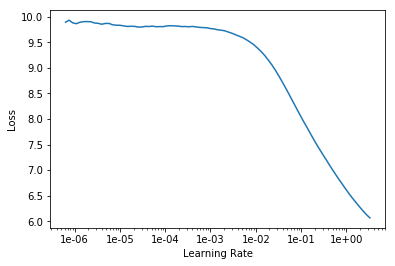

In [71]:
learn.recorder.plot()

In [72]:
# train the learner object with learning rate = 1e-2 
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.617359,3.847504,0.297470,00:07


In [73]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.384775,3.600324,0.402679,00:09


In [0]:
learn.save('ft_enc')

In [0]:
learn.load('ft_enc');

In [76]:
learn.predict("Lower limb pain ", n_words=10)

'Lower limb pain  xxbos severe limb xxbos sore difficulty fingers xxbos foot pain'

In [0]:
learn.save_encoder('ft_enc')

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df('./', train_df=train, valid_df=test, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
data_clas.save('data_clas_export.pkl')

In [80]:
data_clas.show_batch()

text,target
xxbos went sit instead sitng normaly would almost fall chair control strength upon getting hold something get,26544005
xxbos stomach hurt s xxrep 4 o bad,271681002
xxbos severe pain muscles shoulder area,76948002
xxbos heel could nt walk well,228158008
xxbos arthritic type pain joints,57676002


In [0]:
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
classifier.load_encoder('ft_enc')

In [82]:
classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


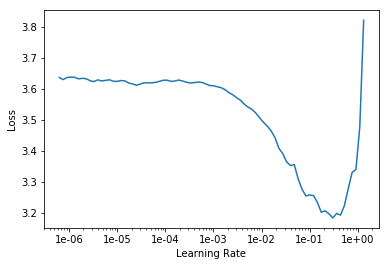

In [83]:
classifier.recorder.plot()

In [84]:
classifier.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.116443,0.748828,0.802549,00:25


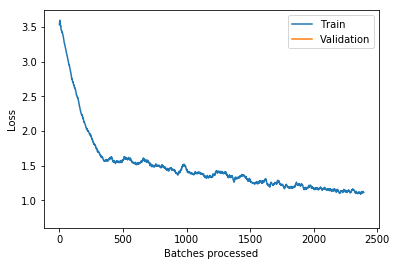

In [85]:
classifier.recorder.plot_losses()

In [0]:
classifier.freeze_to(-2)

In [87]:
classifier.fit_one_cycle(5, slice(5e-3/2., 5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.766892,0.607575,0.836377,00:28
1,0.601197,0.683482,0.859787,00:30
2,0.517198,0.714682,0.866773,00:28
3,0.460804,0.446818,0.903297,00:28
4,0.456099,0.460106,0.901213,00:29


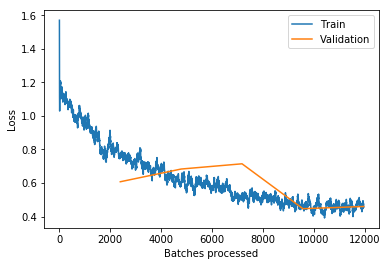

In [88]:
classifier.recorder.plot_losses()

In [0]:
classifier.unfreeze()

In [90]:
classifier.fit_one_cycle(2, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.222253,0.372150,0.897536,00:55
1,0.132646,0.358590,0.906606,00:55


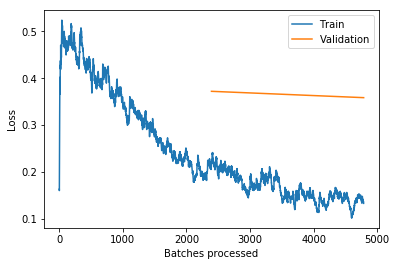

In [91]:
classifier.recorder.plot_losses()

In [92]:
classifier.predict("My stomach hurts! real bad")

(Category 271681002,
 tensor(25),
 tensor([3.6901e-04, 1.8074e-04, 6.3045e-04, 3.0867e-03, 7.5408e-05, 2.6587e-04,
         5.0107e-04, 9.3339e-06, 1.0258e-05, 2.8952e-05, 1.0500e-06, 2.2978e-05,
         3.6800e-06, 2.8859e-05, 9.4171e-05, 6.6257e-04, 3.8159e-07, 4.8760e-04,
         9.9720e-02, 2.0184e-05, 1.9505e-04, 2.2433e-05, 3.3196e-01, 2.5891e-04,
         6.6738e-06, 5.3128e-01, 1.6019e-05, 5.9961e-05, 8.3767e-04, 1.7361e-02,
         4.9153e-06, 3.5457e-04, 1.1006e-02, 4.3686e-04]))

fast text

In [94]:
!pip install fasttext

    100% |████████████████████████████████| 81kB 3.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/73/8e/5d/ecb50b90adaab5868ae1d8df180f31e55e85c2f055aaf2fb35
Successfully built fasttext


In [0]:
import fasttext

In [97]:
train.columns

Index(['label', 'text'], dtype='object')

In [0]:
train['Disease']=['__label__'+s.replace(' or ', '$').replace(', or ','$').replace(',','$').replace(' ','_').replace(',','__label__').replace('$$','$').replace('$',' __label__').replace('___','__') for s in train['Disease']]

In [0]:
test['Disease']=['__label__'+s.replace(' or ', '$').replace(', or ','$').replace(',','$').replace(' ','_').replace(',','__label__').replace('$$','$').replace('$',' __label__').replace('___','__') for s in test['Disease']]

In [133]:
train.head()

,Disease,Patient Complaint Narrative
1,__label__Arthrotec,arthrotec
3,__label__Lipitor,lipitor
5,__label__Dizziness,dizziness
6,__label__Stomach_ache,stomach ache
7,__label__Severe_pain,severe pain


In [134]:
test.head()

,Disease,Patient Complaint Narrative
1,__label__Arthrotec,arthrotec
3,__label__Lipitor,lipitor
5,__label__Dizziness,dizzy
6,__label__Stomach_ache,pain pit stomach
7,__label__Severe_pain,extreme muscle pain shoulders


In [0]:
train.to_csv(r'/content/train.txt', encoding='utf-8', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

In [0]:
test.to_csv(r'/content/test.txt', encoding='utf-8', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

In [0]:
train = train.drop(['CUID'], axis = 1)

In [0]:
test = test.drop(['CUID'], axis = 1)

In [0]:
classifier = fasttext.supervised('train.txt', 'model', epoch=200, min_count=1)

In [0]:
classifier = fasttext.load_model('model.bin', label_prefix='some_prefix')

In [138]:
text = ['Muscle pain']
labels = classifier.predict_proba(text)
print(labels)

[[('__label__Shoulder_pain', 0.539063)]]


In [0]:
result = classifier.test('test.txt')

In [140]:
print('Number of examples:', result.nexamples)

Number of examples: 8159


In [141]:
result.precision

1.0

In [142]:
result.recall

1.0

Out of all 4 models considered, fast text appears to perform best followed by BERT, fast ai and LSTM.